<a href="https://colab.research.google.com/github/jithsg/MODELING/blob/main/Yet_another_copy_of_Yet_another_copy_of_Hybrid_pmos-2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install optuna


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 386.6/386.6 kB 8.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 231.9/231.9 kB 20.3 MB/s eta 0:00:00


In [ ]:
import optuna
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split


import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from tensorflow.keras.callbacks import ModelCheckpoint


device_files = [
    "pfet_120_40.csv",
    "pfet_200_40.csv",
    "pfet_200_80.csv",
    "pfet_400_40.csv",
    "pfet_800_40.csv"
]

flattened_vectors = []
per_device_raw_data = []

for path in device_files:
    df = pd.read_csv(path).sort_values(by=["Vgs(V)", "Vds(V)"])
    Id = df["Id(A)"].values
    gm = df["gm"].values
    gds = df["gds"].values
    flat = np.stack([Id, gm, gds], axis=1).flatten()
    flattened_vectors.append(flat)
    per_device_raw_data.append(df)

device_matrix = np.array(flattened_vectors)
pca = PCA(n_components=3)
device_signatures = pca.fit_transform(device_matrix)

X, y_id, y_gm, y_gd = [], [], [], []
for i, df in enumerate(per_device_raw_data):
    P = device_signatures[i]
    for _, row in df.iterrows():
        vgs = row["Vgs(V)"]
        vds = row["Vds(V)"]
        temp = row["Temp"]
        id_val = max(row["Id(A)"], 1e-12)
        gm_val = row["gm"]
        gd_val = row["gds"]
        X.append([*P, vgs, vds, temp])
        y_id.append(np.log10(id_val))
        y_gm.append(gm_val)
        y_gd.append(gd_val)

X = np.array(X)
y_id = np.array(y_id)
y_gm = np.array(y_gm)
y_gd = np.array(y_gd)

scaler_gm = StandardScaler()
scaler_gd = StandardScaler()
y_gm_scaled = scaler_gm.fit_transform(y_gm.reshape(-1, 1)).flatten()
y_gd_scaled = scaler_gd.fit_transform(y_gd.reshape(-1, 1)).flatten()

scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)
y_combined = np.stack([y_id, y_gm_scaled, y_gd_scaled], axis=1)

# === X_scaled, y_combined must be defined from your preprocessing ===
# X_scaled → shape (n_samples, 6)
# y_combined → shape (n_samples, 3) [log10(Id), gm_scaled, gd_scaled]

X_train_opt, X_val_opt, y_train_opt, y_val_opt = train_test_split(X_scaled, y_combined, test_size=0.2, random_state=42)

# === Optuna Objective Function ===
def objective(trial):
    # Loss term weights to tune
    w_Id   = trial.suggest_float("w_Id", 2.0, 6.0)
    w_gm   = trial.suggest_float("w_gm", 1.0, 4.0)
    w_gd   = trial.suggest_float("w_gd", 0.5, 2.0)
    w_gm_s = trial.suggest_float("w_gm_smooth", 0.001, 0.05)
    w_gd_s = trial.suggest_float("w_gd_smooth", 0.001, 0.05)
    w_gm_2 = trial.suggest_float("w_gm_second", 0.0001, 0.01)
    w_gd_2 = trial.suggest_float("w_gd_second", 0.0001, 0.01)

    # Define loss function with trial weights
    def hybrid_loss_opt(y_true, y_pred):
        log_Id_true = y_true[:, 0]
        gm_true     = y_true[:, 1]
        gd_true     = y_true[:, 2]

        log_Id_pred = y_pred[:, 0]
        gm_pred     = y_pred[:, 1]
        gd_pred     = y_pred[:, 2]

        loss_Id = tf.reduce_mean(tf.square(log_Id_true - log_Id_pred))
        loss_gm = tf.reduce_mean(tf.square(gm_true - gm_pred))
        loss_gd = tf.reduce_mean(tf.square(gd_true - gd_pred))

        gm_smooth = tf.reduce_mean(tf.square(gm_pred[1:] - gm_pred[:-1]))
        gd_smooth = tf.reduce_mean(tf.square(gd_pred[1:] - gd_pred[:-1]))

        gm_second = tf.reduce_mean(tf.square(gm_pred[2:] - 2 * gm_pred[1:-1] + gm_pred[:-2]))
        gd_second = tf.reduce_mean(tf.square(gd_pred[2:] - 2 * gd_pred[1:-1] + gd_pred[:-2]))

        return (
            w_Id * loss_Id +
            w_gm * loss_gm +
            w_gd * loss_gd +
            w_gm_s * gm_smooth +
            w_gd_s * gd_smooth +
            w_gm_2 * gm_second +
            w_gd_2 * gd_second
        )

    # Define model
    model = Sequential([
        Input(shape=(6,)),
        Dense(64, activation='tanh'),
        Dense(64, activation='tanh'),
        Dense(64, activation='tanh'),
        Dense(64, activation='tanh'),
        Dense(3)
    ])
    model.compile(optimizer=Adam(learning_rate=0.001), loss=hybrid_loss_opt)

    # Fit model
    model.fit(
        X_train_opt, y_train_opt,
        validation_data=(X_val_opt, y_val_opt),
        epochs=100,
        batch_size=64,
        verbose=0,
        callbacks=[EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)]
    )

    # Evaluate validation I_ds MSE
    y_val_pred = model.predict(X_val_opt)
    log_Id_true = y_val_opt[:, 0]
    log_Id_pred = y_val_pred[:, 0]
    Id_true = 10 ** log_Id_true
    Id_pred = 10 ** log_Id_pred

    return mean_squared_error(Id_true, Id_pred)

# === Run Optuna Study ===
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=30)

# === Print Best Parameters ===
print("\nBest loss weights found:")
for key, val in study.best_params.items():
    print(f"{key}: {val:.4f}")


[I 2025-05-09 16:45:25,270] A new study created in memory with name: no-name-bb9b455c-ba27-4b0b-8588-4eca6f89fa6a


59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step


[I 2025-05-09 16:46:03,388] Trial 0 finished with value: 1.284293655411943e-10 and parameters: {'w_Id': 2.525108474635792, 'w_gm': 2.61870608267413, 'w_gd': 0.9552660127757965, 'w_gm_smooth': 0.02637151617074354, 'w_gd_smooth': 0.010370954638079976, 'w_gm_second': 0.008410063504682626, 'w_gd_second': 0.007545490410725906}. Best is trial 0 with value: 1.284293655411943e-10.


59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


[I 2025-05-09 16:46:31,632] Trial 1 finished with value: 2.328867075043509e-10 and parameters: {'w_Id': 5.74099868178114, 'w_gm': 1.6641366078491098, 'w_gd': 1.3376589533527865, 'w_gm_smooth': 0.03128062067905941, 'w_gd_smooth': 0.026971809292195507, 'w_gm_second': 0.008131869342449813, 'w_gd_second': 0.009763331966929547}. Best is trial 0 with value: 1.284293655411943e-10.


59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


[I 2025-05-09 16:47:04,126] Trial 2 finished with value: 2.1503969397893068e-10 and parameters: {'w_Id': 5.210864068713551, 'w_gm': 2.4567804855131286, 'w_gd': 1.4570894550492506, 'w_gm_smooth': 0.015235584068062104, 'w_gd_smooth': 0.047709953337632754, 'w_gm_second': 0.0002882898628717637, 'w_gd_second': 0.0037377452557540505}. Best is trial 0 with value: 1.284293655411943e-10.


59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


[I 2025-05-09 16:47:41,723] Trial 3 finished with value: 1.0970864292143141e-10 and parameters: {'w_Id': 2.5733139820865008, 'w_gm': 1.5636681338427767, 'w_gd': 1.2837947620985761, 'w_gm_smooth': 0.005339624499626156, 'w_gd_smooth': 0.03588261398845419, 'w_gm_second': 0.008090132286054482, 'w_gd_second': 0.0027249730445105293}. Best is trial 3 with value: 1.0970864292143141e-10.


59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


[I 2025-05-09 16:48:07,795] Trial 4 finished with value: 4.449782141917571e-10 and parameters: {'w_Id': 5.714855843363008, 'w_gm': 1.431664774275986, 'w_gd': 0.8419695687128987, 'w_gm_smooth': 0.03766535518833621, 'w_gd_smooth': 0.0035263095019293887, 'w_gm_second': 0.0023090336595153857, 'w_gd_second': 0.001858558893205015}. Best is trial 3 with value: 1.0970864292143141e-10.


59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


[I 2025-05-09 16:48:40,377] Trial 5 finished with value: 1.9872607084867326e-10 and parameters: {'w_Id': 4.921425905914983, 'w_gm': 3.210657016217744, 'w_gd': 1.182327338128778, 'w_gm_smooth': 0.048168578202739336, 'w_gd_smooth': 0.03648288624323011, 'w_gm_second': 0.0036606441085774615, 'w_gd_second': 0.009980825819554869}. Best is trial 3 with value: 1.0970864292143141e-10.


59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


[I 2025-05-09 16:49:10,124] Trial 6 finished with value: 4.3163468879461184e-08 and parameters: {'w_Id': 2.6119603015713793, 'w_gm': 3.143202737796021, 'w_gd': 1.6282002708977306, 'w_gm_smooth': 0.0347554569935443, 'w_gd_smooth': 0.04850628519757475, 'w_gm_second': 0.0033917804592477154, 'w_gd_second': 0.008725303382350521}. Best is trial 3 with value: 1.0970864292143141e-10.


59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


[I 2025-05-09 16:49:45,192] Trial 7 finished with value: 1.03582207529973e-10 and parameters: {'w_Id': 4.798155010651325, 'w_gm': 2.581478232440331, 'w_gd': 1.533429675828571, 'w_gm_smooth': 0.019438177938510603, 'w_gd_smooth': 0.02436087124893307, 'w_gm_second': 0.006481188064761129, 'w_gd_second': 0.006438926415808942}. Best is trial 7 with value: 1.03582207529973e-10.


59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


[I 2025-05-09 16:50:24,280] Trial 8 finished with value: 2.5170592503726784e-10 and parameters: {'w_Id': 3.3672755645470382, 'w_gm': 1.3935205002788558, 'w_gd': 0.7984867831772668, 'w_gm_smooth': 0.00655070023758318, 'w_gd_smooth': 0.005972494651898182, 'w_gm_second': 0.009701910218783177, 'w_gd_second': 0.006783040237440222}. Best is trial 7 with value: 1.03582207529973e-10.


59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


[I 2025-05-09 16:50:55,804] Trial 9 finished with value: 1.5291125097527042e-10 and parameters: {'w_Id': 2.713994495311458, 'w_gm': 1.369562812013406, 'w_gd': 1.7213113875636874, 'w_gm_smooth': 0.0016106568534056754, 'w_gd_smooth': 0.0029816978848805293, 'w_gm_second': 0.001983758631221469, 'w_gd_second': 0.008874857649013473}. Best is trial 7 with value: 1.03582207529973e-10.


59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


[I 2025-05-09 16:51:34,835] Trial 10 finished with value: 2.200655060246602e-10 and parameters: {'w_Id': 4.267675136360571, 'w_gm': 3.8803499597771416, 'w_gd': 1.9951740718700375, 'w_gm_smooth': 0.017203356740203297, 'w_gd_smooth': 0.017520068925201412, 'w_gm_second': 0.006172460192624349, 'w_gd_second': 0.00023713378126987653}. Best is trial 7 with value: 1.03582207529973e-10.


59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


[I 2025-05-09 16:52:08,235] Trial 11 finished with value: 1.4010636798723745e-10 and parameters: {'w_Id': 3.952808633760487, 'w_gm': 2.0497269387903403, 'w_gd': 0.5425675521242903, 'w_gm_smooth': 0.014800340166855237, 'w_gd_smooth': 0.030926808782296783, 'w_gm_second': 0.006156881291788535, 'w_gd_second': 0.004686671716369662}. Best is trial 7 with value: 1.03582207529973e-10.


59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


[I 2025-05-09 16:52:40,615] Trial 12 finished with value: 1.996460857200093e-10 and parameters: {'w_Id': 2.0490503953758172, 'w_gm': 2.053465014421755, 'w_gd': 1.103878728261562, 'w_gm_smooth': 0.009363626970260178, 'w_gd_smooth': 0.03521050956991325, 'w_gm_second': 0.00692600052805965, 'w_gd_second': 0.003157232775888227}. Best is trial 7 with value: 1.03582207529973e-10.


59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


[I 2025-05-09 16:53:13,836] Trial 13 finished with value: 3.205469888577667e-10 and parameters: {'w_Id': 4.338522253476978, 'w_gm': 1.0167385097682766, 'w_gd': 1.5416690570383245, 'w_gm_smooth': 0.02261238507546403, 'w_gd_smooth': 0.016653917557890488, 'w_gm_second': 0.004636166150313364, 'w_gd_second': 0.00596532597501202}. Best is trial 7 with value: 1.03582207529973e-10.


59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


[I 2025-05-09 16:53:47,181] Trial 14 finished with value: 2.2621477020709267e-10 and parameters: {'w_Id': 3.5495004946985196, 'w_gm': 2.795423647141415, 'w_gd': 1.8180039416638083, 'w_gm_smooth': 0.00789589257072473, 'w_gd_smooth': 0.041233699286558956, 'w_gm_second': 0.007841099243133923, 'w_gd_second': 0.002142098051867045}. Best is trial 7 with value: 1.03582207529973e-10.


59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


[I 2025-05-09 16:54:18,351] Trial 15 finished with value: 1.638469930332012e-10 and parameters: {'w_Id': 4.912558497325177, 'w_gm': 2.072246119297343, 'w_gd': 1.354085113711194, 'w_gm_smooth': 0.02150387679162183, 'w_gd_smooth': 0.02159639939201472, 'w_gm_second': 0.009983171433189891, 'w_gd_second': 0.005186192515932755}. Best is trial 7 with value: 1.03582207529973e-10.


59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


[I 2025-05-09 16:54:52,089] Trial 16 finished with value: 1.0248681925654913e-10 and parameters: {'w_Id': 3.2088941303854384, 'w_gm': 3.6969661426950857, 'w_gd': 1.0623633314871652, 'w_gm_smooth': 0.002148469175921847, 'w_gd_smooth': 0.026620994954633492, 'w_gm_second': 0.005149324713964281, 'w_gd_second': 0.0001667748119033763}. Best is trial 16 with value: 1.0248681925654913e-10.


59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


[I 2025-05-09 16:55:28,875] Trial 17 finished with value: 1.8407121240854644e-10 and parameters: {'w_Id': 3.297808377921649, 'w_gm': 3.973850946210488, 'w_gd': 0.5735251753508795, 'w_gm_smooth': 0.04353901146375848, 'w_gd_smooth': 0.0248270245874676, 'w_gm_second': 0.005249247843890989, 'w_gd_second': 0.0009394319391177474}. Best is trial 16 with value: 1.0248681925654913e-10.


59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


[I 2025-05-09 16:56:06,568] Trial 18 finished with value: 9.307551393587296e-11 and parameters: {'w_Id': 3.947713893807383, 'w_gm': 3.580130182558091, 'w_gd': 1.0310470392455926, 'w_gm_smooth': 0.028616939096605933, 'w_gd_smooth': 0.01406579762566183, 'w_gm_second': 0.004505151412378951, 'w_gd_second': 0.004511328276431005}. Best is trial 18 with value: 9.307551393587296e-11.


59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


[I 2025-05-09 16:56:45,590] Trial 19 finished with value: 7.255931304594216e-11 and parameters: {'w_Id': 3.7996858459916356, 'w_gm': 3.5916236164965616, 'w_gd': 1.0632788936064497, 'w_gm_smooth': 0.02773364813840763, 'w_gd_smooth': 0.012407471368941067, 'w_gm_second': 0.004404892096928941, 'w_gd_second': 0.004340213566792695}. Best is trial 19 with value: 7.255931304594216e-11.


59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


[I 2025-05-09 16:57:21,946] Trial 20 finished with value: 1.184521714307075e-10 and parameters: {'w_Id': 3.884271182735457, 'w_gm': 3.4420896571706683, 'w_gd': 0.7589776364146769, 'w_gm_smooth': 0.027865228701586697, 'w_gd_smooth': 0.011152411360281831, 'w_gm_second': 0.003851359362946332, 'w_gd_second': 0.004372744369261027}. Best is trial 19 with value: 7.255931304594216e-11.


59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


[I 2025-05-09 16:57:59,612] Trial 21 finished with value: 1.5588605411720707e-10 and parameters: {'w_Id': 3.11963457694195, 'w_gm': 3.6185477803708155, 'w_gd': 1.0683599502921888, 'w_gm_smooth': 0.030847774100267428, 'w_gd_smooth': 0.015005232477606857, 'w_gm_second': 0.005024020201367263, 'w_gd_second': 0.005309073948684901}. Best is trial 19 with value: 7.255931304594216e-11.


59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


[I 2025-05-09 16:58:32,791] Trial 22 finished with value: 2.285717577112841e-10 and parameters: {'w_Id': 3.670477457897224, 'w_gm': 3.633328393574852, 'w_gd': 0.9785785349164164, 'w_gm_smooth': 0.03870227989422652, 'w_gd_smooth': 0.01016720667500716, 'w_gm_second': 0.002685640728744839, 'w_gd_second': 0.003637077064017359}. Best is trial 19 with value: 7.255931304594216e-11.


59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


[I 2025-05-09 16:59:00,223] Trial 23 finished with value: 3.369380223430565e-10 and parameters: {'w_Id': 4.336927103180093, 'w_gm': 3.4117816453582717, 'w_gd': 0.9564329204388701, 'w_gm_smooth': 0.024703443817555987, 'w_gd_smooth': 0.020122122992244352, 'w_gm_second': 0.004535644865410349, 'w_gd_second': 0.0014688689448707367}. Best is trial 19 with value: 7.255931304594216e-11.


59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


[I 2025-05-09 16:59:31,002] Trial 24 finished with value: 4.922811253969567e-10 and parameters: {'w_Id': 3.1073239013725518, 'w_gm': 3.0217776875197555, 'w_gd': 1.1721467857798233, 'w_gm_smooth': 0.03252403899007173, 'w_gd_smooth': 0.029032007779478407, 'w_gm_second': 0.005500112401901968, 'w_gd_second': 0.0004529525783629213}. Best is trial 19 with value: 7.255931304594216e-11.


59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


[I 2025-05-09 17:00:04,743] Trial 25 finished with value: 1.8551501090114462e-10 and parameters: {'w_Id': 2.938903657262007, 'w_gm': 3.7026912617958363, 'w_gd': 0.6863577693738838, 'w_gm_smooth': 0.012013372112282752, 'w_gd_smooth': 0.014987155911189048, 'w_gm_second': 0.0011906977606225048, 'w_gd_second': 0.0025952709343939275}. Best is trial 19 with value: 7.255931304594216e-11.


59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


[I 2025-05-09 17:00:38,860] Trial 26 finished with value: 2.426662917457488e-10 and parameters: {'w_Id': 3.6971379764751613, 'w_gm': 3.364925948801799, 'w_gd': 1.0656523217886225, 'w_gm_smooth': 0.02877631011014691, 'w_gd_smooth': 0.0077321474916973235, 'w_gm_second': 0.004334878852914713, 'w_gd_second': 0.004189106872757616}. Best is trial 19 with value: 7.255931304594216e-11.


59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


[I 2025-05-09 17:01:16,583] Trial 27 finished with value: 3.659958664586927e-10 and parameters: {'w_Id': 4.213119023020789, 'w_gm': 2.9213828409814337, 'w_gd': 1.2124886600346112, 'w_gm_smooth': 0.04133177009670118, 'w_gd_smooth': 0.012951940762991079, 'w_gm_second': 0.003112699458080374, 'w_gd_second': 0.0073716778835000146}. Best is trial 19 with value: 7.255931304594216e-11.


59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


[I 2025-05-09 17:01:55,733] Trial 28 finished with value: 9.603513669873365e-11 and parameters: {'w_Id': 4.522009126203086, 'w_gm': 3.7234913488032917, 'w_gd': 0.9648942212348361, 'w_gm_smooth': 0.02359402553546139, 'w_gd_smooth': 0.020933232718399933, 'w_gm_second': 0.007114180710681702, 'w_gd_second': 0.005681471272363093}. Best is trial 19 with value: 7.255931304594216e-11.


59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


[I 2025-05-09 17:02:24,303] Trial 29 finished with value: 3.6335967144004525e-10 and parameters: {'w_Id': 4.60033953916491, 'w_gm': 3.8560756718881173, 'w_gd': 0.8584955971285357, 'w_gm_smooth': 0.025267183231564655, 'w_gd_smooth': 0.020459404180900028, 'w_gm_second': 0.007309697243629962, 'w_gd_second': 0.005712400499140809}. Best is trial 19 with value: 7.255931304594216e-11.



Best loss weights found:
w_Id: 3.7997
w_gm: 3.5916
w_gd: 1.0633
w_gm_smooth: 0.0277
w_gd_smooth: 0.0124
w_gm_second: 0.0044
w_gd_second: 0.0043


In [2]:

def hybrid_loss(y_true, y_pred):
    log_Id_true = y_true[:, 0]
    gm_true     = y_true[:, 1]
    gd_true     = y_true[:, 2]

    log_Id_pred = y_pred[:, 0]
    gm_pred     = y_pred[:, 1]
    gd_pred     = y_pred[:, 2]

    loss_Id = tf.reduce_mean(tf.square(log_Id_true - log_Id_pred))
    log_Id_smooth = tf.reduce_mean(tf.square(log_Id_pred[1:] - log_Id_pred[:-1]))
    log_Id_second = tf.reduce_mean(tf.square(log_Id_pred[2:] - 2 * log_Id_pred[1:-1] + log_Id_pred[:-2]))

    loss_gm = tf.reduce_mean(tf.square(gm_true - gm_pred))
    loss_gd = tf.reduce_mean(tf.square(gd_true - gd_pred))

    gm_smooth = tf.reduce_mean(tf.square(gm_pred[1:] - gm_pred[:-1]))
    gd_smooth = tf.reduce_mean(tf.square(gd_pred[1:] - gd_pred[:-1]))

    gm_second = tf.reduce_mean(tf.square(gm_pred[2:] - 2 * gm_pred[1:-1] + gm_pred[:-2]))
    gd_second = tf.reduce_mean(tf.square(gd_pred[2:] - 2 * gd_pred[1:-1] + gd_pred[:-2]))

    return (
        3.7997 * loss_Id +
        3.5916 * loss_gm +
        1.0633 * loss_gd +
        0.0277 * gm_smooth +
        0.0124 * gd_smooth +
        0.0044 * gm_second +
        0.0043 * gd_second

    )

In [3]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from tensorflow.keras.callbacks import ModelCheckpoint


device_files = [
    "pfet_120_40.csv",
    "pfet_200_40.csv",
    "pfet_200_80.csv",
    "pfet_400_40.csv",
    "pfet_800_40.csv"
]

flattened_vectors = []
per_device_raw_data = []

for path in device_files:
    df = pd.read_csv(path).sort_values(by=["Vgs(V)", "Vds(V)"])
    Id = df["Id(A)"].values
    gm = df["gm"].values
    gds = df["gds"].values
    flat = np.stack([Id, gm, gds], axis=1).flatten()
    flattened_vectors.append(flat)
    per_device_raw_data.append(df)

device_matrix = np.array(flattened_vectors)
pca = PCA(n_components=3)
device_signatures = pca.fit_transform(device_matrix)

X, y_id, y_gm, y_gd = [], [], [], []
for i, df in enumerate(per_device_raw_data):
    P = device_signatures[i]
    for _, row in df.iterrows():
        vgs = row["Vgs(V)"]
        vds = row["Vds(V)"]
        temp = row["Temp"]
        id_val = max(row["Id(A)"], 1e-12)
        gm_val = row["gm"]
        gd_val = row["gds"]
        X.append([*P, vgs, vds, temp])
        y_id.append(np.log10(id_val))
        y_gm.append(gm_val)
        y_gd.append(gd_val)

X = np.array(X)
y_id = np.array(y_id)
y_gm = np.array(y_gm)
y_gd = np.array(y_gd)

scaler_gm = StandardScaler()
scaler_gd = StandardScaler()
y_gm_scaled = scaler_gm.fit_transform(y_gm.reshape(-1, 1)).flatten()
y_gd_scaled = scaler_gd.fit_transform(y_gd.reshape(-1, 1)).flatten()

scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)
y_combined = np.stack([y_id, y_gm_scaled, y_gd_scaled], axis=1)

# Step 2: Train/Test Split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_combined, test_size=0.2, random_state=42)

In [43]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint
# import optuna
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

final_model = Sequential([
    Input(shape=(6,)),
    Dense(64, activation='tanh'),
    Dense(64, activation='tanh'),
    Dense(64, activation='tanh'),
    Dense(64, activation='tanh'),
    Dense(3)
])

final_model.compile(optimizer=Adam(learning_rate=0.001), loss=hybrid_loss)

# Save best model
checkpoint = ModelCheckpoint(
    "best_final_model.h5",
    monitor="val_loss",
    save_best_only=True,
    mode="min",
    verbose=1
)

# Train with validation split
history = final_model.fit(
    X_train, y_train,
    validation_split=0.25,
    epochs=500,
    batch_size=150,
    verbose=1,
    callbacks=[checkpoint]
)



Epoch 1/500
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 62.3335
Epoch 1: val_loss improved from inf to 16.62152, saving model to best_final_model.h5


38/38 ━━━━━━━━━━━━━━━━━━━━ 6s 61ms/step - loss: 61.6737 - val_loss: 16.6215
Epoch 2/500
27/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 14.5956 
Epoch 2: val_loss improved from 16.62152 to 12.78475, saving model to best_final_model.h5


38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 14.3306 - val_loss: 12.7847
Epoch 3/500
27/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 12.5393 
Epoch 3: val_loss improved from 12.78475 to 12.10277, saving model to best_final_model.h5


38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 12.4106 - val_loss: 12.1028
Epoch 4/500
28/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 11.7977 
Epoch 4: val_loss improved from 12.10277 to 11.66090, saving model to best_final_model.h5


38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 11.7269 - val_loss: 11.6609
Epoch 5/500
28/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 11.4681 
Epoch 5: val_loss improved from 11.66090 to 11.27765, saving model to best_final_model.h5


38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 11.4006 - val_loss: 11.2776
Epoch 6/500
28/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 11.1312 
Epoch 6: val_loss improved from 11.27765 to 11.07055, saving model to best_final_model.h5


38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 11.0173 - val_loss: 11.0705
Epoch 7/500
27/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 10.8511 
Epoch 7: val_loss improved from 11.07055 to 10.49506, saving model to best_final_model.h5


38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 10.7795 - val_loss: 10.4951
Epoch 8/500
27/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 10.0748 
Epoch 8: val_loss improved from 10.49506 to 10.11436, saving model to best_final_model.h5


38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 10.1069 - val_loss: 10.1144
Epoch 9/500
27/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 9.8866  
Epoch 9: val_loss improved from 10.11436 to 9.57385, saving model to best_final_model.h5


38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 9.8299 - val_loss: 9.5738
Epoch 10/500
27/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 9.5887 
Epoch 10: val_loss improved from 9.57385 to 8.96724, saving model to best_final_model.h5


38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 9.5075 - val_loss: 8.9672
Epoch 11/500
27/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 9.1505  
Epoch 11: val_loss improved from 8.96724 to 7.99995, saving model to best_final_model.h5


38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 8.9968 - val_loss: 8.0000
Epoch 12/500
27/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 8.2123  
Epoch 12: val_loss improved from 7.99995 to 6.78267, saving model to best_final_model.h5


38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 8.0397 - val_loss: 6.7827
Epoch 13/500
28/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6.7587 
Epoch 13: val_loss improved from 6.78267 to 5.36894, saving model to best_final_model.h5


38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 6.7045 - val_loss: 5.3689
Epoch 14/500
28/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5.7142 
Epoch 14: val_loss improved from 5.36894 to 4.52121, saving model to best_final_model.h5


38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 5.6449 - val_loss: 4.5212
Epoch 15/500
28/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4.8272 
Epoch 15: val_loss improved from 4.52121 to 4.02028, saving model to best_final_model.h5


38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.8115 - val_loss: 4.0203
Epoch 16/500
28/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4.7265 
Epoch 16: val_loss improved from 4.02028 to 3.84711, saving model to best_final_model.h5


38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.6452 - val_loss: 3.8471
Epoch 17/500
28/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4.8674 
Epoch 17: val_loss improved from 3.84711 to 3.84484, saving model to best_final_model.h5


38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.6781 - val_loss: 3.8448
Epoch 18/500
28/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.4806 
Epoch 18: val_loss improved from 3.84484 to 3.53136, saving model to best_final_model.h5


38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 3.6237 - val_loss: 3.5314
Epoch 19/500
28/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4.3226 
Epoch 19: val_loss improved from 3.53136 to 3.43948, saving model to best_final_model.h5


38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.1641 - val_loss: 3.4395
Epoch 20/500
27/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.5753 
Epoch 20: val_loss improved from 3.43948 to 3.17045, saving model to best_final_model.h5


38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 3.5854 - val_loss: 3.1705
Epoch 21/500
27/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.5658 
Epoch 21: val_loss improved from 3.17045 to 3.00064, saving model to best_final_model.h5


38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 3.5480 - val_loss: 3.0006
Epoch 22/500
27/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.1280 
Epoch 22: val_loss improved from 3.00064 to 2.93159, saving model to best_final_model.h5


38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 3.1771 - val_loss: 2.9316
Epoch 23/500
28/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.3104 
Epoch 23: val_loss did not improve from 2.93159
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 3.2639 - val_loss: 3.2272
Epoch 24/500
27/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.2498 
Epoch 24: val_loss improved from 2.93159 to 2.74223, saving model to best_final_model.h5


38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 3.2112 - val_loss: 2.7422
Epoch 25/500
27/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.9461 
Epoch 25: val_loss improved from 2.74223 to 2.59170, saving model to best_final_model.h5


38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 2.9380 - val_loss: 2.5917
Epoch 26/500
27/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.9641 
Epoch 26: val_loss improved from 2.59170 to 2.55395, saving model to best_final_model.h5


38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 2.9064 - val_loss: 2.5540
Epoch 27/500
27/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.9637 
Epoch 27: val_loss improved from 2.55395 to 2.46354, saving model to best_final_model.h5


38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 2.8713 - val_loss: 2.4635
Epoch 28/500
26/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.5142 
Epoch 28: val_loss improved from 2.46354 to 2.35987, saving model to best_final_model.h5


38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 2.5231 - val_loss: 2.3599
Epoch 29/500
28/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.2972 
Epoch 29: val_loss did not improve from 2.35987
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 2.3364 - val_loss: 2.3838
Epoch 30/500
28/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.3894 
Epoch 30: val_loss improved from 2.35987 to 2.21073, saving model to best_final_model.h5


38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 2.3769 - val_loss: 2.2107
Epoch 31/500
28/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.6501 
Epoch 31: val_loss did not improve from 2.21073
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 2.5633 - val_loss: 2.3725
Epoch 32/500
28/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.4496 
Epoch 32: val_loss improved from 2.21073 to 2.04125, saving model to best_final_model.h5


38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 2.4158 - val_loss: 2.0413
Epoch 33/500
28/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.9754 
Epoch 33: val_loss improved from 2.04125 to 2.00286, saving model to best_final_model.h5


38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 2.0264 - val_loss: 2.0029
Epoch 34/500
26/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.1376 
Epoch 34: val_loss improved from 2.00286 to 1.88508, saving model to best_final_model.h5


38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 2.1034 - val_loss: 1.8851
Epoch 35/500
28/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.0238 
Epoch 35: val_loss improved from 1.88508 to 1.82408, saving model to best_final_model.h5


38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 2.0292 - val_loss: 1.8241
Epoch 36/500
27/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.0227 
Epoch 36: val_loss improved from 1.82408 to 1.77084, saving model to best_final_model.h5


38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.9967 - val_loss: 1.7708
Epoch 37/500
27/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.8706 
Epoch 37: val_loss improved from 1.77084 to 1.73562, saving model to best_final_model.h5


38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.8507 - val_loss: 1.7356
Epoch 38/500
28/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.6612 
Epoch 38: val_loss improved from 1.73562 to 1.69499, saving model to best_final_model.h5


38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.6783 - val_loss: 1.6950
Epoch 39/500
26/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.5366 
Epoch 39: val_loss did not improve from 1.69499
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.5911 - val_loss: 2.4912
Epoch 40/500
28/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.0075 
Epoch 40: val_loss improved from 1.69499 to 1.67633, saving model to best_final_model.h5


38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.9165 - val_loss: 1.6763
Epoch 41/500
28/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.7754 
Epoch 41: val_loss did not improve from 1.67633
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.7641 - val_loss: 1.7818
Epoch 42/500
27/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.5281 
Epoch 42: val_loss improved from 1.67633 to 1.47650, saving model to best_final_model.h5


38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.5059 - val_loss: 1.4765
Epoch 43/500
26/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.5110 
Epoch 43: val_loss did not improve from 1.47650
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.5234 - val_loss: 1.8750
Epoch 44/500
26/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.4230 
Epoch 44: val_loss improved from 1.47650 to 1.26182, saving model to best_final_model.h5


38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.4020 - val_loss: 1.2618
Epoch 45/500
24/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.4309 
Epoch 45: val_loss did not improve from 1.26182
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.4136 - val_loss: 1.4445
Epoch 46/500
27/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.2224 
Epoch 46: val_loss did not improve from 1.26182
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.2348 - val_loss: 1.4720
Epoch 47/500
28/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.3208 
Epoch 47: val_loss improved from 1.26182 to 1.23574, saving model to best_final_model.h5


38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.3097 - val_loss: 1.2357
Epoch 48/500
26/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.9395 
Epoch 48: val_loss did not improve from 1.23574
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.0036 - val_loss: 1.2601
Epoch 49/500
26/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.3685 
Epoch 49: val_loss did not improve from 1.23574
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.3191 - val_loss: 1.2967
Epoch 50/500
26/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.1530 
Epoch 50: val_loss did not improve from 1.23574
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.1582 - val_loss: 1.3714
Epoch 51/500
27/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.4351 
Epoch 51: val_loss improved from 1.23574 to 1.22634, saving model to best_final_model.h5


38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.3865 - val_loss: 1.2263
Epoch 52/500
27/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.0912 
Epoch 52: val_loss did not improve from 1.22634
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.0708 - val_loss: 1.5472
Epoch 53/500
28/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.9656 
Epoch 53: val_loss did not improve from 1.22634
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.9448 - val_loss: 1.2684
Epoch 54/500
28/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.0066 
Epoch 54: val_loss improved from 1.22634 to 0.94622, saving model to best_final_model.h5


38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.9885 - val_loss: 0.9462
Epoch 55/500
27/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.8799 
Epoch 55: val_loss did not improve from 0.94622
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.9277 - val_loss: 1.1901
Epoch 56/500
28/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.2513 
Epoch 56: val_loss did not improve from 0.94622
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.2228 - val_loss: 1.0578
Epoch 57/500
28/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.0811 
Epoch 57: val_loss improved from 0.94622 to 0.90012, saving model to best_final_model.h5


38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.0558 - val_loss: 0.9001
Epoch 58/500
28/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.7484 
Epoch 58: val_loss did not improve from 0.90012
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.7731 - val_loss: 1.0090
Epoch 59/500
28/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.7274 
Epoch 59: val_loss improved from 0.90012 to 0.81377, saving model to best_final_model.h5


38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.7167 - val_loss: 0.8138
Epoch 60/500
27/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6907 
Epoch 60: val_loss did not improve from 0.81377
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6781 - val_loss: 1.5484
Epoch 61/500
28/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.9034 
Epoch 61: val_loss improved from 0.81377 to 0.75295, saving model to best_final_model.h5


38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.9138 - val_loss: 0.7529
Epoch 62/500
27/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.8766 
Epoch 62: val_loss improved from 0.75295 to 0.73635, saving model to best_final_model.h5


38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.8302 - val_loss: 0.7363
Epoch 63/500
27/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.1144 
Epoch 63: val_loss did not improve from 0.73635
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.0859 - val_loss: 0.8872
Epoch 64/500
27/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.7881 
Epoch 64: val_loss improved from 0.73635 to 0.72398, saving model to best_final_model.h5


38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.7650 - val_loss: 0.7240
Epoch 65/500
27/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6356 
Epoch 65: val_loss improved from 0.72398 to 0.60609, saving model to best_final_model.h5


38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.6167 - val_loss: 0.6061
Epoch 66/500
27/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5650 
Epoch 66: val_loss improved from 0.60609 to 0.57736, saving model to best_final_model.h5


38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.5453 - val_loss: 0.5774
Epoch 67/500
27/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4834 
Epoch 67: val_loss improved from 0.57736 to 0.51354, saving model to best_final_model.h5


38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.4806 - val_loss: 0.5135
Epoch 68/500
27/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5667 
Epoch 68: val_loss improved from 0.51354 to 0.47783, saving model to best_final_model.h5


38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.5698 - val_loss: 0.4778
Epoch 69/500
28/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5458 
Epoch 69: val_loss did not improve from 0.47783
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.5637 - val_loss: 0.5859
Epoch 70/500
28/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4970 
Epoch 70: val_loss improved from 0.47783 to 0.41617, saving model to best_final_model.h5


38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.4905 - val_loss: 0.4162
Epoch 71/500
28/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3552 
Epoch 71: val_loss did not improve from 0.41617
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.3609 - val_loss: 0.6637
Epoch 72/500
28/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6290 
Epoch 72: val_loss did not improve from 0.41617
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6413 - val_loss: 0.4222
Epoch 73/500
28/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3909 
Epoch 73: val_loss did not improve from 0.41617
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.4092 - val_loss: 0.7435
Epoch 74/500
28/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5064 
Epoch 74: val_loss did not improve from 0.41617
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.4849 - val_loss: 0.6657
Epoch 75/500
28/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.7860 
Epoch 75: val_loss did not improve from 0.41617
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.7791 -

38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.8909 - val_loss: 0.4067
Epoch 77/500
27/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3827 
Epoch 77: val_loss did not improve from 0.40674
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.3723 - val_loss: 0.4200
Epoch 78/500
28/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3825 
Epoch 78: val_loss improved from 0.40674 to 0.31923, saving model to best_final_model.h5


38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.3760 - val_loss: 0.3192
Epoch 79/500
27/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3255 
Epoch 79: val_loss did not improve from 0.31923
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.3193 - val_loss: 0.3401
Epoch 80/500
28/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2769 
Epoch 80: val_loss did not improve from 0.31923
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2830 - val_loss: 0.6589
Epoch 81/500
28/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6755 
Epoch 81: val_loss did not improve from 0.31923
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6326 - val_loss: 0.3361
Epoch 82/500
27/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3504 
Epoch 82: val_loss improved from 0.31923 to 0.30119, saving model to best_final_model.h5


38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.3456 - val_loss: 0.3012
Epoch 83/500
28/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2846 
Epoch 83: val_loss did not improve from 0.30119
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.3039 - val_loss: 0.3437
Epoch 84/500
27/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2713 
Epoch 84: val_loss improved from 0.30119 to 0.28449, saving model to best_final_model.h5


38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.2737 - val_loss: 0.2845
Epoch 85/500
26/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2808 
Epoch 85: val_loss did not improve from 0.28449
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2730 - val_loss: 0.2943
Epoch 86/500
27/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2517 
Epoch 86: val_loss improved from 0.28449 to 0.26346, saving model to best_final_model.h5


38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.2506 - val_loss: 0.2635
Epoch 87/500
28/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2870 
Epoch 87: val_loss did not improve from 0.26346
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2822 - val_loss: 0.4929
Epoch 88/500
28/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5487 
Epoch 88: val_loss did not improve from 0.26346
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.5201 - val_loss: 0.2638
Epoch 89/500
28/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2382 
Epoch 89: val_loss improved from 0.26346 to 0.26128, saving model to best_final_model.h5


38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.2426 - val_loss: 0.2613
Epoch 90/500
28/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2449 
Epoch 90: val_loss did not improve from 0.26128
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2422 - val_loss: 0.2790
Epoch 91/500
28/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2862 
Epoch 91: val_loss improved from 0.26128 to 0.23618, saving model to best_final_model.h5


38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.2780 - val_loss: 0.2362
Epoch 92/500
27/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2156 
Epoch 92: val_loss improved from 0.23618 to 0.22847, saving model to best_final_model.h5


38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.2172 - val_loss: 0.2285
Epoch 93/500
27/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2476 
Epoch 93: val_loss did not improve from 0.22847
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2537 - val_loss: 0.2742
Epoch 94/500
28/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3074 
Epoch 94: val_loss did not improve from 0.22847
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.3368 - val_loss: 1.1033
Epoch 95/500
27/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4720 
Epoch 95: val_loss improved from 0.22847 to 0.22691, saving model to best_final_model.h5


38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.4351 - val_loss: 0.2269
Epoch 96/500
28/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2125 
Epoch 96: val_loss did not improve from 0.22691
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2127 - val_loss: 0.4221
Epoch 97/500
29/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3245 
Epoch 97: val_loss did not improve from 0.22691
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.3448 - val_loss: 0.2775
Epoch 98/500
28/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4461 
Epoch 98: val_loss did not improve from 0.22691
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.4266 - val_loss: 0.2511
Epoch 99/500
28/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2264 
Epoch 99: val_loss did not improve from 0.22691
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2268 - val_loss: 0.2281
Epoch 100/500
27/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2091 
Epoch 100: val_loss did not improve from 0.22691
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2195

38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.2170 - val_loss: 0.2157
Epoch 105/500
27/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2068 
Epoch 105: val_loss improved from 0.21570 to 0.20055, saving model to best_final_model.h5


38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.2060 - val_loss: 0.2005
Epoch 106/500
27/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2085 
Epoch 106: val_loss did not improve from 0.20055
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2046 - val_loss: 0.2309
Epoch 107/500
28/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2309 
Epoch 107: val_loss did not improve from 0.20055
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2328 - val_loss: 0.2239
Epoch 108/500
26/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1943 
Epoch 108: val_loss did not improve from 0.20055
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1922 - val_loss: 0.2156
Epoch 109/500
27/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2064 
Epoch 109: val_loss improved from 0.20055 to 0.18880, saving model to best_final_model.h5


38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.2047 - val_loss: 0.1888
Epoch 110/500
26/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1956 
Epoch 110: val_loss did not improve from 0.18880
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1961 - val_loss: 0.2588
Epoch 111/500
27/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1974 
Epoch 111: val_loss did not improve from 0.18880
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1954 - val_loss: 0.2425
Epoch 112/500
27/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2172 
Epoch 112: val_loss did not improve from 0.18880
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2135 - val_loss: 0.2146
Epoch 113/500
27/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1929 
Epoch 113: val_loss did not improve from 0.18880
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1979 - val_loss: 0.2927
Epoch 114/500
26/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2340 
Epoch 114: val_loss did not improve from 0.18880
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss

38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1821 - val_loss: 0.1856
Epoch 125/500
27/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1738 
Epoch 125: val_loss did not improve from 0.18563
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1740 - val_loss: 0.2054
Epoch 126/500
28/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1975 
Epoch 126: val_loss improved from 0.18563 to 0.18210, saving model to best_final_model.h5


38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1927 - val_loss: 0.1821
Epoch 127/500
28/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1710 
Epoch 127: val_loss did not improve from 0.18210
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1710 - val_loss: 0.1865
Epoch 128/500
28/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1640 
Epoch 128: val_loss improved from 0.18210 to 0.17801, saving model to best_final_model.h5


38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1682 - val_loss: 0.1780
Epoch 129/500
27/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2527 
Epoch 129: val_loss did not improve from 0.17801
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.3063 - val_loss: 0.4388
Epoch 130/500
27/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.3327 
Epoch 130: val_loss did not improve from 0.17801
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.2495 - val_loss: 0.4579
Epoch 131/500
28/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3486 
Epoch 131: val_loss did not improve from 0.17801
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.3329 - val_loss: 0.2170
Epoch 132/500
28/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2139 
Epoch 132: val_loss did not improve from 0.17801
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2107 - val_loss: 0.2565
Epoch 133/500
27/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2377 
Epoch 133: val_loss did not improve from 0.17801
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss

38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1968 - val_loss: 0.1774
Epoch 135/500
28/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1701 
Epoch 135: val_loss did not improve from 0.17739
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1716 - val_loss: 0.1795
Epoch 136/500
28/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1616 
Epoch 136: val_loss did not improve from 0.17739
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1645 - val_loss: 0.1978
Epoch 137/500
27/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1820 
Epoch 137: val_loss did not improve from 0.17739
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1822 - val_loss: 0.1885
Epoch 138/500
27/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1895 
Epoch 138: val_loss did not improve from 0.17739
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1861 - val_loss: 0.1802
Epoch 139/500
28/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1764 
Epoch 139: val_loss did not improve from 0.17739
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss

38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1584 - val_loss: 0.1740
Epoch 142/500
27/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1809 
Epoch 142: val_loss improved from 0.17403 to 0.16965, saving model to best_final_model.h5


38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1789 - val_loss: 0.1697
Epoch 143/500
27/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1645 
Epoch 143: val_loss did not improve from 0.16965
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1704 - val_loss: 0.1853
Epoch 144/500
28/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1745 
Epoch 144: val_loss did not improve from 0.16965
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1729 - val_loss: 0.3075
Epoch 145/500
28/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3065 
Epoch 145: val_loss did not improve from 0.16965
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.3292 - val_loss: 1.2887
Epoch 146/500
28/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.8991 
Epoch 146: val_loss did not improve from 0.16965
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.8542 - val_loss: 0.5238
Epoch 147/500
27/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4140 
Epoch 147: val_loss did not improve from 0.16965
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss

38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1710 - val_loss: 0.1665
Epoch 158/500
28/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1697 
Epoch 158: val_loss did not improve from 0.16651
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1681 - val_loss: 0.1737
Epoch 159/500
27/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1618 
Epoch 159: val_loss improved from 0.16651 to 0.16359, saving model to best_final_model.h5


38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1614 - val_loss: 0.1636
Epoch 160/500
28/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1707 
Epoch 160: val_loss did not improve from 0.16359
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1675 - val_loss: 0.1831
Epoch 161/500
28/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1823 
Epoch 161: val_loss did not improve from 0.16359
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1792 - val_loss: 0.1864
Epoch 162/500
28/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2026 
Epoch 162: val_loss did not improve from 0.16359
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2054 - val_loss: 0.3035
Epoch 163/500
27/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.8205 
Epoch 163: val_loss did not improve from 0.16359
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.9281 - val_loss: 0.9593
Epoch 164/500
27/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.0722 
Epoch 164: val_loss did not improve from 0.16359
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss

38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1675 - val_loss: 0.1636
Epoch 178/500
29/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1647 
Epoch 178: val_loss did not improve from 0.16356
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1646 - val_loss: 0.1705
Epoch 179/500
29/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1576 
Epoch 179: val_loss did not improve from 0.16356
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1590 - val_loss: 0.1745
Epoch 180/500
29/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2263 
Epoch 180: val_loss did not improve from 0.16356
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2206 - val_loss: 0.1649
Epoch 181/500
29/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1611 
Epoch 181: val_loss did not improve from 0.16356
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1614 - val_loss: 0.1938
Epoch 182/500
28/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1956 
Epoch 182: val_loss did not improve from 0.16356
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss

38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1655 - val_loss: 0.1617
Epoch 184/500
27/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1647 
Epoch 184: val_loss did not improve from 0.16173
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1621 - val_loss: 0.1657
Epoch 185/500
28/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1560 
Epoch 185: val_loss improved from 0.16173 to 0.16155, saving model to best_final_model.h5


38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1564 - val_loss: 0.1615
Epoch 186/500
28/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1543 
Epoch 186: val_loss did not improve from 0.16155
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1545 - val_loss: 0.1875
Epoch 187/500
29/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1608 
Epoch 187: val_loss improved from 0.16155 to 0.15663, saving model to best_final_model.h5


38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1596 - val_loss: 0.1566
Epoch 188/500
28/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1543 
Epoch 188: val_loss did not improve from 0.15663
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1545 - val_loss: 0.1699
Epoch 189/500
28/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1526 
Epoch 189: val_loss did not improve from 0.15663
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1545 - val_loss: 0.1897
Epoch 190/500
28/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1887 
Epoch 190: val_loss did not improve from 0.15663
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1880 - val_loss: 0.2195
Epoch 191/500
28/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3694 
Epoch 191: val_loss did not improve from 0.15663
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.4121 - val_loss: 0.2815
Epoch 192/500
28/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5373 
Epoch 192: val_loss did not improve from 0.15663
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss

38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1528 - val_loss: 0.1550
Epoch 216/500
29/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1564 
Epoch 216: val_loss did not improve from 0.15495
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1571 - val_loss: 0.1568
Epoch 217/500
28/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1536 
Epoch 217: val_loss improved from 0.15495 to 0.15219, saving model to best_final_model.h5


38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1523 - val_loss: 0.1522
Epoch 218/500
28/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1663 
Epoch 218: val_loss did not improve from 0.15219
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1670 - val_loss: 0.1589
Epoch 219/500
28/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1657 
Epoch 219: val_loss did not improve from 0.15219
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1623 - val_loss: 0.1524
Epoch 220/500
29/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1384 
Epoch 220: val_loss did not improve from 0.15219
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1402 - val_loss: 0.1542
Epoch 221/500
28/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1492 
Epoch 221: val_loss did not improve from 0.15219
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1480 - val_loss: 0.1646
Epoch 222/500
29/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1650 
Epoch 222: val_loss did not improve from 0.15219
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss

38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1572 - val_loss: 0.1512
Epoch 229/500
27/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1458 
Epoch 229: val_loss did not improve from 0.15115
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1464 - val_loss: 0.1550
Epoch 230/500
28/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1461 
Epoch 230: val_loss did not improve from 0.15115
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1477 - val_loss: 0.1623
Epoch 231/500
27/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1500 
Epoch 231: val_loss did not improve from 0.15115
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1527 - val_loss: 0.1742
Epoch 232/500
27/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1484 
Epoch 232: val_loss improved from 0.15115 to 0.14893, saving model to best_final_model.h5


38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1480 - val_loss: 0.1489
Epoch 233/500
27/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1436 
Epoch 233: val_loss did not improve from 0.14893
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1442 - val_loss: 0.1494
Epoch 234/500
27/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1559 
Epoch 234: val_loss did not improve from 0.14893
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1593 - val_loss: 0.1625
Epoch 235/500
27/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1620 
Epoch 235: val_loss did not improve from 0.14893
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1624 - val_loss: 0.1535
Epoch 236/500
27/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1366 
Epoch 236: val_loss did not improve from 0.14893
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1390 - val_loss: 0.1601
Epoch 237/500
27/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1531 
Epoch 237: val_loss did not improve from 0.14893
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss

38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1435 - val_loss: 0.1487
Epoch 264/500
28/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1515 
Epoch 264: val_loss improved from 0.14869 to 0.14722, saving model to best_final_model.h5


38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1497 - val_loss: 0.1472
Epoch 265/500
27/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1411 
Epoch 265: val_loss did not improve from 0.14722
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1426 - val_loss: 0.1476
Epoch 266/500
28/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1397 
Epoch 266: val_loss improved from 0.14722 to 0.14693, saving model to best_final_model.h5


38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1409 - val_loss: 0.1469
Epoch 267/500
28/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1438 
Epoch 267: val_loss did not improve from 0.14693
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1425 - val_loss: 0.1478
Epoch 268/500
29/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1406 
Epoch 268: val_loss improved from 0.14693 to 0.14572, saving model to best_final_model.h5


38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1414 - val_loss: 0.1457
Epoch 269/500
28/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1392 
Epoch 269: val_loss did not improve from 0.14572
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1409 - val_loss: 0.1499
Epoch 270/500
28/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1528 
Epoch 270: val_loss did not improve from 0.14572
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1509 - val_loss: 0.1462
Epoch 271/500
28/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1425 
Epoch 271: val_loss did not improve from 0.14572
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1420 - val_loss: 0.1460
Epoch 272/500
28/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1435 
Epoch 272: val_loss did not improve from 0.14572
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1433 - val_loss: 0.1520
Epoch 273/500
28/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1315 
Epoch 273: val_loss did not improve from 0.14572
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss

38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1398 - val_loss: 0.1455
Epoch 314/500
27/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1377 
Epoch 314: val_loss did not improve from 0.14550
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1381 - val_loss: 0.1472
Epoch 315/500
27/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1372 
Epoch 315: val_loss did not improve from 0.14550
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1384 - val_loss: 0.1510
Epoch 316/500
27/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1424 
Epoch 316: val_loss did not improve from 0.14550
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1429 - val_loss: 0.1460
Epoch 317/500
28/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1415 
Epoch 317: val_loss improved from 0.14550 to 0.14415, saving model to best_final_model.h5


38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1414 - val_loss: 0.1442
Epoch 318/500
27/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1413 
Epoch 318: val_loss did not improve from 0.14415
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1410 - val_loss: 0.1485
Epoch 319/500
28/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1596 
Epoch 319: val_loss did not improve from 0.14415
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1561 - val_loss: 0.1503
Epoch 320/500
28/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1555 
Epoch 320: val_loss did not improve from 0.14415
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1530 - val_loss: 0.1474
Epoch 321/500
28/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1495 
Epoch 321: val_loss did not improve from 0.14415
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1471 - val_loss: 0.1443
Epoch 322/500
28/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1508 
Epoch 322: val_loss did not improve from 0.14415
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss

38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1418 - val_loss: 0.1428
Epoch 327/500
28/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1473 
Epoch 327: val_loss did not improve from 0.14280
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1470 - val_loss: 0.1478
Epoch 328/500
28/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1437 
Epoch 328: val_loss did not improve from 0.14280
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1449 - val_loss: 0.1760
Epoch 329/500
28/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1563 
Epoch 329: val_loss did not improve from 0.14280
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1538 - val_loss: 0.1484
Epoch 330/500
27/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1454 
Epoch 330: val_loss did not improve from 0.14280
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1438 - val_loss: 0.1502
Epoch 331/500
28/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1442 
Epoch 331: val_loss did not improve from 0.14280
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss

38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1382 - val_loss: 0.1417
Epoch 341/500
27/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1296 
Epoch 341: val_loss did not improve from 0.14166
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1311 - val_loss: 0.1420
Epoch 342/500
28/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1384 
Epoch 342: val_loss did not improve from 0.14166
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1380 - val_loss: 0.1440
Epoch 343/500
28/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1383 
Epoch 343: val_loss did not improve from 0.14166
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1388 - val_loss: 0.1466
Epoch 344/500
27/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1446 
Epoch 344: val_loss did not improve from 0.14166
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1458 - val_loss: 0.1455
Epoch 345/500
28/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1436 
Epoch 345: val_loss did not improve from 0.14166
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss

38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1390 - val_loss: 0.1409
Epoch 377/500
27/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1361 
Epoch 377: val_loss did not improve from 0.14086
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1363 - val_loss: 0.1435
Epoch 378/500
28/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1353 
Epoch 378: val_loss did not improve from 0.14086
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1364 - val_loss: 0.1441
Epoch 379/500
28/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1382 
Epoch 379: val_loss did not improve from 0.14086
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1379 - val_loss: 0.1426
Epoch 380/500
28/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1500 
Epoch 380: val_loss did not improve from 0.14086
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1469 - val_loss: 0.1455
Epoch 381/500
28/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1456 
Epoch 381: val_loss did not improve from 0.14086
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss

38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1423 - val_loss: 0.1405
Epoch 384/500
27/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1441 
Epoch 384: val_loss did not improve from 0.14052
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1427 - val_loss: 0.1421
Epoch 385/500
28/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1413 
Epoch 385: val_loss did not improve from 0.14052
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1410 - val_loss: 0.1467
Epoch 386/500
29/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1420 
Epoch 386: val_loss did not improve from 0.14052
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1416 - val_loss: 0.1424
Epoch 387/500
27/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1382 
Epoch 387: val_loss improved from 0.14052 to 0.14021, saving model to best_final_model.h5


38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1387 - val_loss: 0.1402
Epoch 388/500
28/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1371 
Epoch 388: val_loss did not improve from 0.14021
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1383 - val_loss: 0.1532
Epoch 389/500
28/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1459 
Epoch 389: val_loss did not improve from 0.14021
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1454 - val_loss: 0.1413
Epoch 390/500
28/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1439 
Epoch 390: val_loss did not improve from 0.14021
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1428 - val_loss: 0.1407
Epoch 391/500
28/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1380 
Epoch 391: val_loss improved from 0.14021 to 0.13900, saving model to best_final_model.h5


38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1374 - val_loss: 0.1390
Epoch 392/500
27/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1356 
Epoch 392: val_loss did not improve from 0.13900
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1357 - val_loss: 0.1401
Epoch 393/500
27/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1437 
Epoch 393: val_loss did not improve from 0.13900
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1424 - val_loss: 0.1392
Epoch 394/500
28/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1318 
Epoch 394: val_loss did not improve from 0.13900
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1323 - val_loss: 0.1394
Epoch 395/500
27/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1391 
Epoch 395: val_loss did not improve from 0.13900
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1380 - val_loss: 0.1402
Epoch 396/500
27/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1330 
Epoch 396: val_loss did not improve from 0.13900
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss

38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1342 - val_loss: 0.1389
Epoch 435/500
28/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1405 
Epoch 435: val_loss did not improve from 0.13894
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1392 - val_loss: 0.1390
Epoch 436/500
27/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1395 
Epoch 436: val_loss did not improve from 0.13894
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1388 - val_loss: 0.1418
Epoch 437/500
27/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1488 
Epoch 437: val_loss did not improve from 0.13894
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1464 - val_loss: 0.1430
Epoch 438/500
27/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1451 
Epoch 438: val_loss did not improve from 0.13894
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1440 - val_loss: 0.1499
Epoch 439/500
27/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1496 
Epoch 439: val_loss did not improve from 0.13894
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss

38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1385 - val_loss: 0.1388
Epoch 441/500
27/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1281 
Epoch 441: val_loss did not improve from 0.13885
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1298 - val_loss: 0.1394
Epoch 442/500
28/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1423 
Epoch 442: val_loss did not improve from 0.13885
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1424 - val_loss: 0.1399
Epoch 443/500
28/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1372 
Epoch 443: val_loss did not improve from 0.13885
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1365 - val_loss: 0.1401
Epoch 444/500
29/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1373 
Epoch 444: val_loss did not improve from 0.13885
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1376 - val_loss: 0.1392
Epoch 445/500
28/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1367 
Epoch 445: val_loss did not improve from 0.13885
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss

38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1329 - val_loss: 0.1383
Epoch 450/500
27/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1297 
Epoch 450: val_loss did not improve from 0.13830
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1324 - val_loss: 0.1389
Epoch 451/500
28/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1399 
Epoch 451: val_loss did not improve from 0.13830
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1389 - val_loss: 0.1428
Epoch 452/500
29/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1520 
Epoch 452: val_loss did not improve from 0.13830
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1499 - val_loss: 0.1394
Epoch 453/500
27/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1354 
Epoch 453: val_loss did not improve from 0.13830
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1361 - val_loss: 0.1392
Epoch 454/500
28/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1347 
Epoch 454: val_loss did not improve from 0.13830
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss

38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1400 - val_loss: 0.1381
Epoch 493/500
27/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1361 
Epoch 493: val_loss did not improve from 0.13812
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1363 - val_loss: 0.1386
Epoch 494/500
26/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1326 
Epoch 494: val_loss did not improve from 0.13812
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1332 - val_loss: 0.1389
Epoch 495/500
26/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1350 
Epoch 495: val_loss did not improve from 0.13812
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1350 - val_loss: 0.1386
Epoch 496/500
29/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1379 
Epoch 496: val_loss did not improve from 0.13812
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1373 - val_loss: 0.1383
Epoch 497/500
28/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1343 
Epoch 497: val_loss did not improve from 0.13812
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss

38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1376 - val_loss: 0.1378
Epoch 500/500
28/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1383 
Epoch 500: val_loss did not improve from 0.13779
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1376 - val_loss: 0.1402


In [44]:
from tensorflow.keras.models import load_model

model = load_model("best_final_model.h5", custom_objects={"hybrid_loss": hybrid_loss})

# Predict and evaluate on test set
y_pred = model.predict(X_test)
log_Id_pred = y_pred[:, 0]
gm_pred = scaler_gm.inverse_transform(y_pred[:, 1].reshape(-1, 1)).flatten()
gd_pred = scaler_gd.inverse_transform(y_pred[:, 2].reshape(-1, 1)).flatten()

log_Id_true = y_test[:, 0]
gm_true = scaler_gm.inverse_transform(y_test[:, 1].reshape(-1, 1)).flatten()
gd_true = scaler_gd.inverse_transform(y_test[:, 2].reshape(-1, 1)).flatten()

Id_pred = 10 ** log_Id_pred
Id_true = 10 ** log_Id_true

from sklearn.metrics import mean_squared_error, r2_score
def evaluate_metrics(true, pred, label):
    mse = mean_squared_error(true, pred)
    r2 = r2_score(true, pred)
    print(f"{label} → MSE: {mse:.4e}, R²: {r2:.4f}")

evaluate_metrics(Id_true, Id_pred, "Final NN I_ds")
evaluate_metrics(gm_true, gm_pred, "Final gm")
evaluate_metrics(gd_true, gd_pred, "Final gd")


59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
Final NN I_ds → MSE: 3.6609e-11, R²: 0.9991
Final gm → MSE: 1.2692e-11, R²: 0.9993
Final gd → MSE: 4.7118e-11, R²: 0.9968


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step


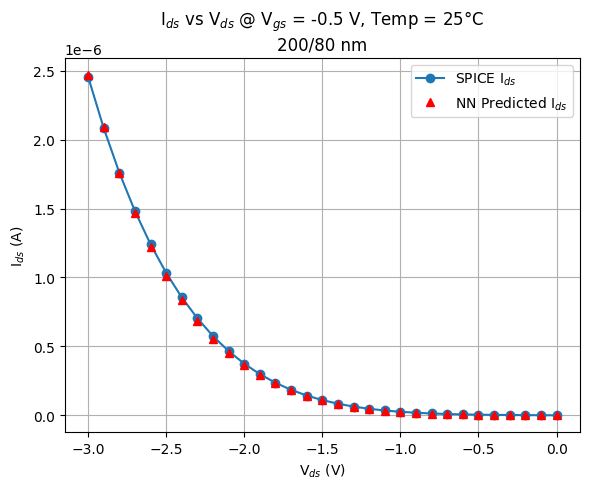

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


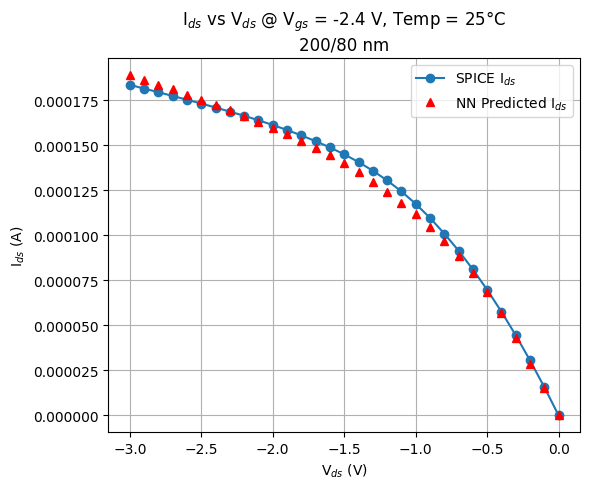

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


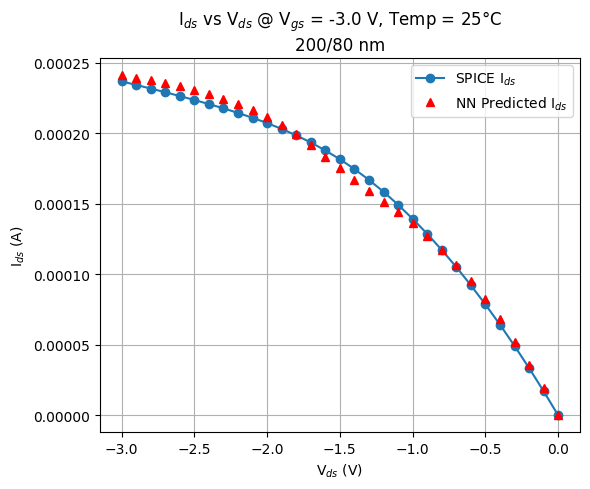

In [45]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# File for Device 1 (nfet_120_40)
df_spice = pd.read_csv("/content/pfet_200_80.csv").sort_values(by=["Vgs(V)", "Vds(V)"])
signature = device_signatures[2]  # PCA vector for Device 1
TEMP_TARGET = 25
VGS_TARGETS = [-0.5, -2.4, -3.0]

for VGS_TARGET in VGS_TARGETS:
    # Filter SPICE data
    mask = (df_spice["Vgs(V)"] == VGS_TARGET) & (df_spice["Temp"] == TEMP_TARGET)
    df_filtered = df_spice[mask].sort_values(by="Vds(V)")

    if df_filtered.empty:
        print(f"⚠️ No SPICE data found for Vgs = {VGS_TARGET} V at {TEMP_TARGET}°C")
        continue

    # Prepare model input
    X_input = [[*signature, row["Vgs(V)"], row["Vds(V)"], row["Temp"]] for _, row in df_filtered.iterrows()]
    X_scaled_input = scaler.transform(X_input)

    # Predict [log_Id, gm_scaled, gd_scaled]
    y_pred = model.predict(X_scaled_input)
    log_Id_pred = y_pred[:, 0]
    Id_pred = 10 ** log_Id_pred

    # Get SPICE values
    Id_spice = df_filtered["Id(A)"].values
    Vds_vals = df_filtered["Vds(V)"].values

    # Plot I_ds vs V_ds
    plt.figure(figsize=(6, 5))
    plt.plot(Vds_vals, Id_spice, "o-", label="SPICE I$_{ds}$")
    # plt.plot(Vds_vals, Id_pred, "s--", label="NN Predicted I$_{ds}$")
    plt.plot(Vds_vals, Id_pred, "^", color='red', label="NN Predicted I$_{ds}$")  # '^' = triangle up


    plt.xlabel("V$_{ds}$ (V)")
    plt.ylabel("I$_{ds}$ (A)")
    plt.title(f"I$_{{ds}}$ vs V$_{{ds}}$ @ V$_{{gs}}$ = {VGS_TARGET} V, Temp = {TEMP_TARGET}°C\n200/80 nm")

    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


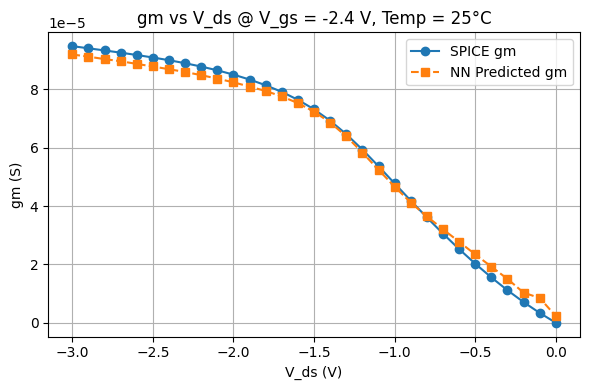

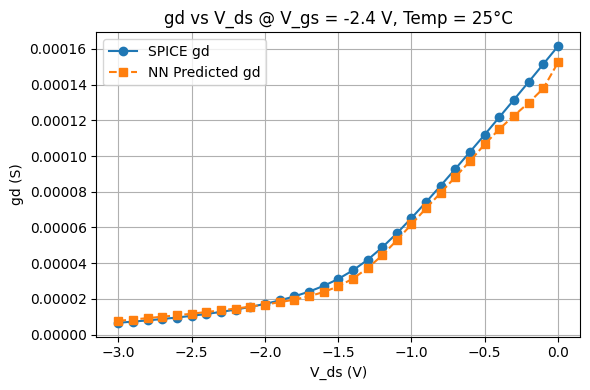

In [46]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Set Vgs and temperature for comparison
VGS_TARGET = -2.4
TEMP_TARGET = 25

# Load and filter SPICE data
df_spice = pd.read_csv("/content/pfet_200_80.csv").sort_values(by=["Vgs(V)", "Vds(V)"])
mask = (df_spice["Vgs(V)"] == VGS_TARGET) & (df_spice["Temp"] == TEMP_TARGET)
df_filtered = df_spice[mask].sort_values(by="Vds(V)")

if df_filtered.empty:
    print(f"⚠️ No data found for Vgs={VGS_TARGET} V, Temp={TEMP_TARGET}°C")
else:
    # Prepare input
    signature = device_signatures[2]  # Device 1
    X_plot = [[*signature, row["Vgs(V)"], row["Vds(V)"], row["Temp"]] for _, row in df_filtered.iterrows()]
    X_plot_scaled = scaler.transform(X_plot)

    # Predict with model → outputs: [log10(Id), gm_scaled, gd_scaled]
    y_pred = model.predict(X_plot_scaled)
    gm_pred_scaled = y_pred[:, 1]
    gd_pred_scaled = y_pred[:, 2]

    # Invert standard scaling
    gm_pred = scaler_gm.inverse_transform(gm_pred_scaled.reshape(-1, 1)).flatten()
    gd_pred = scaler_gd.inverse_transform(gd_pred_scaled.reshape(-1, 1)).flatten()

    # True gm and gd
    gm_spice = df_filtered["gm"].values
    gd_spice = df_filtered["gds"].values
    vds_vals = df_filtered["Vds(V)"].values

    # Plot gm
    plt.figure(figsize=(6, 4))
    plt.plot(vds_vals, gm_spice, "o-", label="SPICE gm")
    plt.plot(vds_vals, gm_pred, "s--", label="NN Predicted gm")
    plt.xlabel("V_ds (V)")
    plt.ylabel("gm (S)")
    plt.title(f"gm vs V_ds @ V_gs = {VGS_TARGET} V, Temp = {TEMP_TARGET}°C")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # Plot gd
    plt.figure(figsize=(6, 4))
    plt.plot(vds_vals, gd_spice, "o-", label="SPICE gd")
    plt.plot(vds_vals, gd_pred, "s--", label="NN Predicted gd")
    plt.xlabel("V_ds (V)")
    plt.ylabel("gd (S)")
    plt.title(f"gd vs V_ds @ V_gs = {VGS_TARGET} V, Temp = {TEMP_TARGET}°C")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


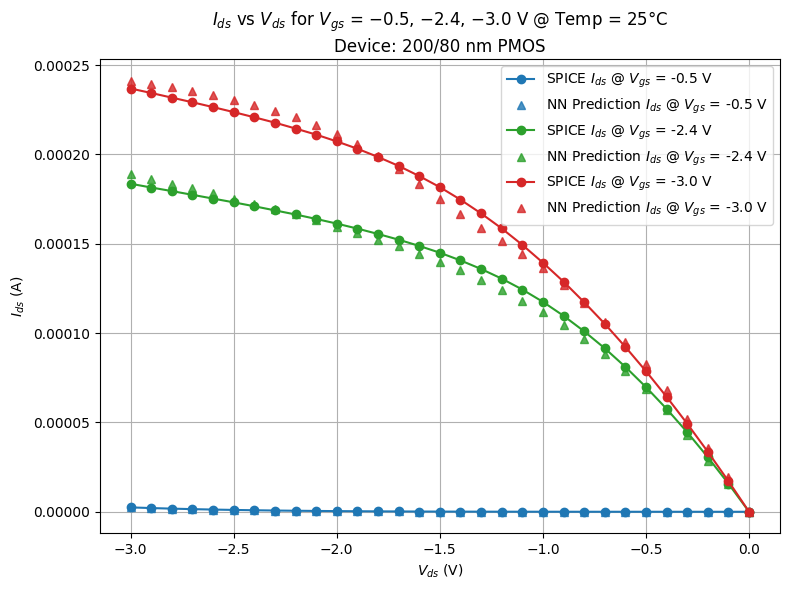

In [47]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# File for PMOS Device 1
df_spice = pd.read_csv("/content/pfet_200_80.csv").sort_values(by=["Vgs(V)", "Vds(V)"])
signature = device_signatures[2]  # PCA vector for pfet_120_40
TEMP_TARGET = 25
VGS_TARGETS = [-0.5, -2.4, -3.0]

# Color map for each Vgs
color_map = {
    -0.5: '#1f77b4',   # blue
    -2.4: '#2ca02c',   # green
    -3.0: '#d62728'    # red
}

# Initialize combined plot
plt.figure(figsize=(8, 6))

for VGS_TARGET in VGS_TARGETS:
    color = color_map[VGS_TARGET]

    # Filter SPICE data
    mask = (df_spice["Vgs(V)"] == VGS_TARGET) & (df_spice["Temp"] == TEMP_TARGET)
    df_filtered = df_spice[mask].sort_values(by="Vds(V)")

    if df_filtered.empty:
        print(f"⚠️ No SPICE data found for Vgs = {VGS_TARGET} V at {TEMP_TARGET}°C")
        continue

    # Prepare model input
    X_input = [[*signature, row["Vgs(V)"], row["Vds(V)"], row["Temp"]] for _, row in df_filtered.iterrows()]
    X_scaled_input = scaler.transform(X_input)
    y_pred = model.predict(X_scaled_input)
    log_Id_pred = y_pred[:, 0]
    Id_pred = 10 ** log_Id_pred

    # Extract values
    Id_spice = df_filtered["Id(A)"].values
    Vds_vals = df_filtered["Vds(V)"].values

    # Plot SPICE and NN with same color, but different markers
    plt.plot(Vds_vals, Id_spice, "o-", color=color, label=f"SPICE $I_{{ds}}$ @ $V_{{gs}}$ = {VGS_TARGET} V")
    plt.plot(Vds_vals, Id_pred, "^", color=color, linestyle="None", alpha=0.8, label=f"NN Prediction $I_{{ds}}$ @ $V_{{gs}}$ = {VGS_TARGET} V")

# Final labels and styling
plt.xlabel("$V_{ds}$ (V)")
plt.ylabel("$I_{ds}$ (A)")
plt.title("$I_{ds}$ vs $V_{ds}$ for $V_{gs}$ = −0.5, −2.4, −3.0 V @ Temp = 25°C\nDevice: 200/80 nm PMOS")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


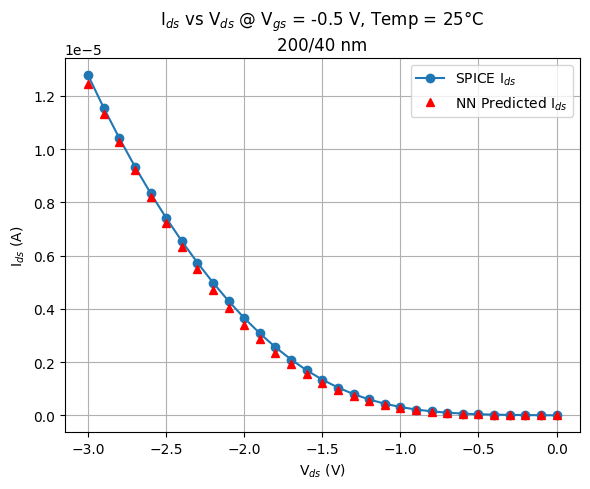

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


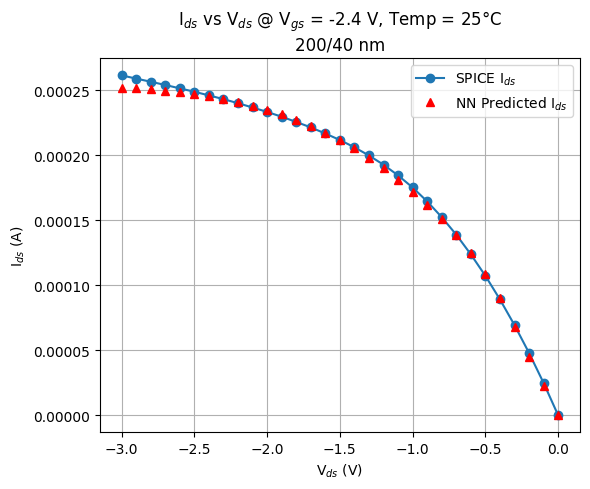

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


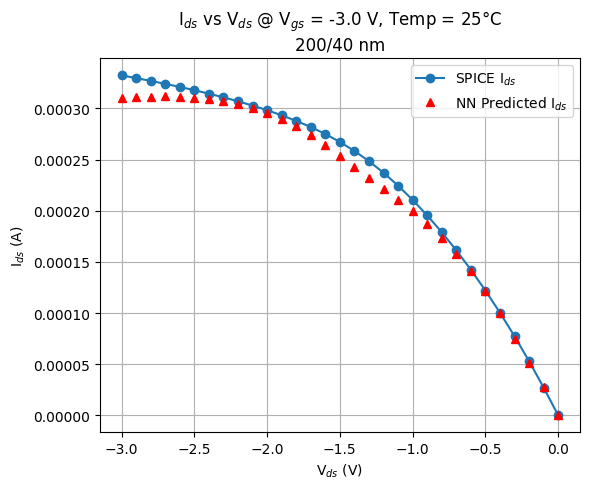

In [48]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# File for Device 1 (nfet_120_40)
df_spice = pd.read_csv("/content/pfet_200_40.csv").sort_values(by=["Vgs(V)", "Vds(V)"])
signature = device_signatures[1]  # PCA vector for Device 1
TEMP_TARGET = 25
VGS_TARGETS = [-0.5, -2.4, -3.0]

for VGS_TARGET in VGS_TARGETS:
    # Filter SPICE data
    mask = (df_spice["Vgs(V)"] == VGS_TARGET) & (df_spice["Temp"] == TEMP_TARGET)
    df_filtered = df_spice[mask].sort_values(by="Vds(V)")

    if df_filtered.empty:
        print(f"⚠️ No SPICE data found for Vgs = {VGS_TARGET} V at {TEMP_TARGET}°C")
        continue

    # Prepare model input
    X_input = [[*signature, row["Vgs(V)"], row["Vds(V)"], row["Temp"]] for _, row in df_filtered.iterrows()]
    X_scaled_input = scaler.transform(X_input)

    # Predict [log_Id, gm_scaled, gd_scaled]
    y_pred = model.predict(X_scaled_input)
    log_Id_pred = y_pred[:, 0]
    Id_pred = 10 ** log_Id_pred

    # Get SPICE values
    Id_spice = df_filtered["Id(A)"].values
    Vds_vals = df_filtered["Vds(V)"].values

    # Plot I_ds vs V_ds
    plt.figure(figsize=(6, 5))
    plt.plot(Vds_vals, Id_spice, "o-", label="SPICE I$_{ds}$")
    # plt.plot(Vds_vals, Id_pred, "s--", label="NN Predicted I$_{ds}$")
    plt.plot(Vds_vals, Id_pred, "^", color='red', label="NN Predicted I$_{ds}$")  # '^' = triangle up


    plt.xlabel("V$_{ds}$ (V)")
    plt.ylabel("I$_{ds}$ (A)")
    plt.title(f"I$_{{ds}}$ vs V$_{{ds}}$ @ V$_{{gs}}$ = {VGS_TARGET} V, Temp = {TEMP_TARGET}°C\n200/40 nm")

    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


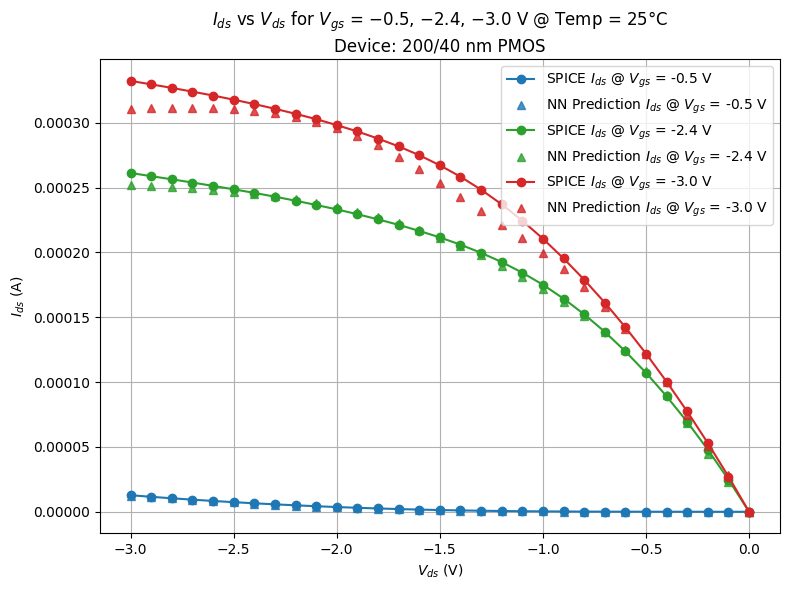

In [49]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# File for PMOS Device 1
df_spice = pd.read_csv("/content/pfet_200_40.csv").sort_values(by=["Vgs(V)", "Vds(V)"])
signature = device_signatures[1]  # PCA vector for pfet_120_40
TEMP_TARGET = 25
VGS_TARGETS = [-0.5, -2.4, -3.0]

# Color map for each Vgs
color_map = {
    -0.5: '#1f77b4',   # blue
    -2.4: '#2ca02c',   # green
    -3.0: '#d62728'    # red
}

# Initialize combined plot
plt.figure(figsize=(8, 6))

for VGS_TARGET in VGS_TARGETS:
    color = color_map[VGS_TARGET]

    # Filter SPICE data
    mask = (df_spice["Vgs(V)"] == VGS_TARGET) & (df_spice["Temp"] == TEMP_TARGET)
    df_filtered = df_spice[mask].sort_values(by="Vds(V)")

    if df_filtered.empty:
        print(f"⚠️ No SPICE data found for Vgs = {VGS_TARGET} V at {TEMP_TARGET}°C")
        continue

    # Prepare model input
    X_input = [[*signature, row["Vgs(V)"], row["Vds(V)"], row["Temp"]] for _, row in df_filtered.iterrows()]
    X_scaled_input = scaler.transform(X_input)
    y_pred = model.predict(X_scaled_input)
    log_Id_pred = y_pred[:, 0]
    Id_pred = 10 ** log_Id_pred

    # Extract values
    Id_spice = df_filtered["Id(A)"].values
    Vds_vals = df_filtered["Vds(V)"].values

    # Plot SPICE and NN with same color, but different markers
    plt.plot(Vds_vals, Id_spice, "o-", color=color, label=f"SPICE $I_{{ds}}$ @ $V_{{gs}}$ = {VGS_TARGET} V")
    plt.plot(Vds_vals, Id_pred, "^", color=color, linestyle="None", alpha=0.8, label=f"NN Prediction $I_{{ds}}$ @ $V_{{gs}}$ = {VGS_TARGET} V")

# Final labels and styling
plt.xlabel("$V_{ds}$ (V)")
plt.ylabel("$I_{ds}$ (A)")
plt.title("$I_{ds}$ vs $V_{ds}$ for $V_{gs}$ = −0.5, −2.4, −3.0 V @ Temp = 25°C\nDevice: 200/40 nm PMOS")
plt.legend(loc='upper right')
plt.grid(True)
plt.tight_layout()
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


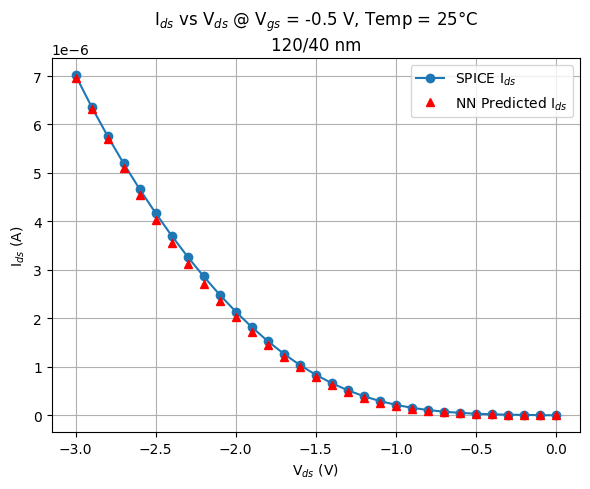

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


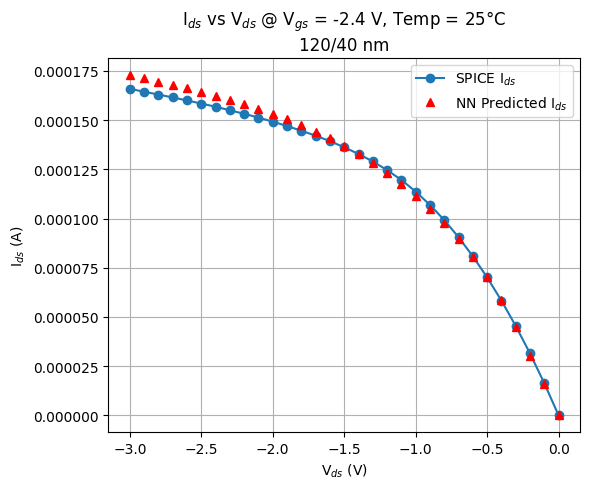

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


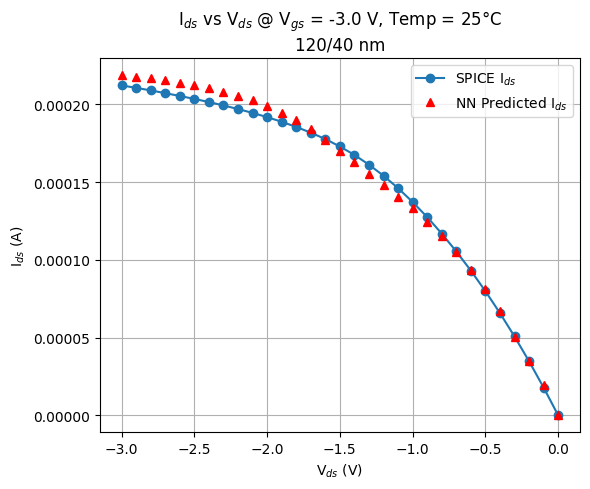

In [50]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# File for Device 1 (nfet_120_40)
df_spice = pd.read_csv("/content/pfet_120_40.csv").sort_values(by=["Vgs(V)", "Vds(V)"])
signature = device_signatures[0]  # PCA vector for Device 1
TEMP_TARGET = 25
VGS_TARGETS = [-0.5, -2.4, -3.0]

for VGS_TARGET in VGS_TARGETS:
    # Filter SPICE data
    mask = (df_spice["Vgs(V)"] == VGS_TARGET) & (df_spice["Temp"] == TEMP_TARGET)
    df_filtered = df_spice[mask].sort_values(by="Vds(V)")

    if df_filtered.empty:
        print(f"⚠️ No SPICE data found for Vgs = {VGS_TARGET} V at {TEMP_TARGET}°C")
        continue

    # Prepare model input
    X_input = [[*signature, row["Vgs(V)"], row["Vds(V)"], row["Temp"]] for _, row in df_filtered.iterrows()]
    X_scaled_input = scaler.transform(X_input)

    # Predict [log_Id, gm_scaled, gd_scaled]
    y_pred = model.predict(X_scaled_input)
    log_Id_pred = y_pred[:, 0]
    Id_pred = 10 ** log_Id_pred

    # Get SPICE values
    Id_spice = df_filtered["Id(A)"].values
    Vds_vals = df_filtered["Vds(V)"].values

    # Plot I_ds vs V_ds
    plt.figure(figsize=(6, 5))
    plt.plot(Vds_vals, Id_spice, "o-", label="SPICE I$_{ds}$")
    # plt.plot(Vds_vals, Id_pred, "s--", label="NN Predicted I$_{ds}$")
    plt.plot(Vds_vals, Id_pred, "^", color='red', label="NN Predicted I$_{ds}$")  # '^' = triangle up


    plt.xlabel("V$_{ds}$ (V)")
    plt.ylabel("I$_{ds}$ (A)")
    plt.title(f"I$_{{ds}}$ vs V$_{{ds}}$ @ V$_{{gs}}$ = {VGS_TARGET} V, Temp = {TEMP_TARGET}°C\n120/40 nm")

    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


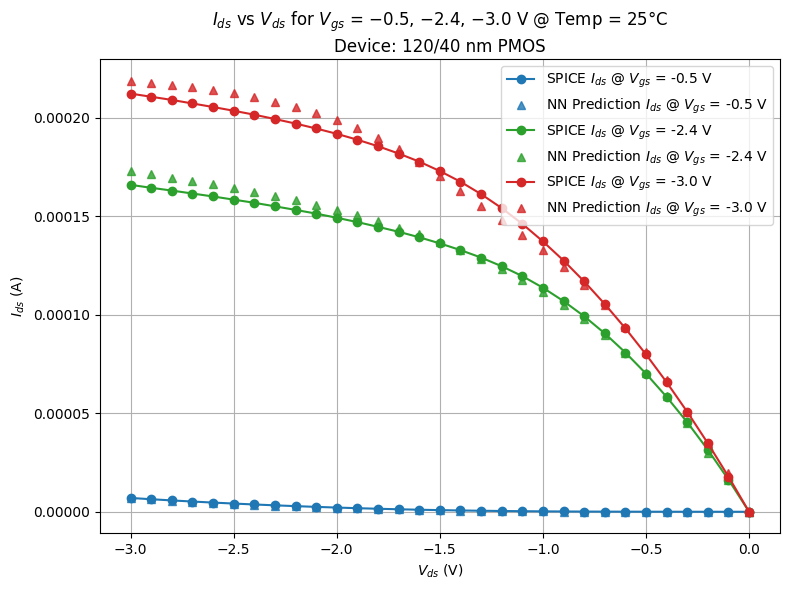

In [51]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# File for PMOS Device 1
df_spice = pd.read_csv("/content/pfet_120_40.csv").sort_values(by=["Vgs(V)", "Vds(V)"])
signature = device_signatures[0]  # PCA vector for pfet_120_40
TEMP_TARGET = 25
VGS_TARGETS = [-0.5, -2.4, -3.0]

# Color map for each Vgs
color_map = {
    -0.5: '#1f77b4',   # blue
    -2.4: '#2ca02c',   # green
    -3.0: '#d62728'    # red
}

# Initialize combined plot
plt.figure(figsize=(8, 6))

for VGS_TARGET in VGS_TARGETS:
    color = color_map[VGS_TARGET]

    # Filter SPICE data
    mask = (df_spice["Vgs(V)"] == VGS_TARGET) & (df_spice["Temp"] == TEMP_TARGET)
    df_filtered = df_spice[mask].sort_values(by="Vds(V)")

    if df_filtered.empty:
        print(f"⚠️ No SPICE data found for Vgs = {VGS_TARGET} V at {TEMP_TARGET}°C")
        continue

    # Prepare model input
    X_input = [[*signature, row["Vgs(V)"], row["Vds(V)"], row["Temp"]] for _, row in df_filtered.iterrows()]
    X_scaled_input = scaler.transform(X_input)
    y_pred = model.predict(X_scaled_input)
    log_Id_pred = y_pred[:, 0]
    Id_pred = 10 ** log_Id_pred

    # Extract values
    Id_spice = df_filtered["Id(A)"].values
    Vds_vals = df_filtered["Vds(V)"].values

    # Plot SPICE and NN with same color, but different markers
    plt.plot(Vds_vals, Id_spice, "o-", color=color, label=f"SPICE $I_{{ds}}$ @ $V_{{gs}}$ = {VGS_TARGET} V")
    plt.plot(Vds_vals, Id_pred, "^", color=color, linestyle="None", alpha=0.8, label=f"NN Prediction $I_{{ds}}$ @ $V_{{gs}}$ = {VGS_TARGET} V")

# Final labels and styling
plt.xlabel("$V_{ds}$ (V)")
plt.ylabel("$I_{ds}$ (A)")
plt.title("$I_{ds}$ vs $V_{ds}$ for $V_{gs}$ = −0.5, −2.4, −3.0 V @ Temp = 25°C\nDevice: 120/40 nm PMOS")
plt.legend(loc='upper right')
plt.grid(True)
plt.tight_layout()
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


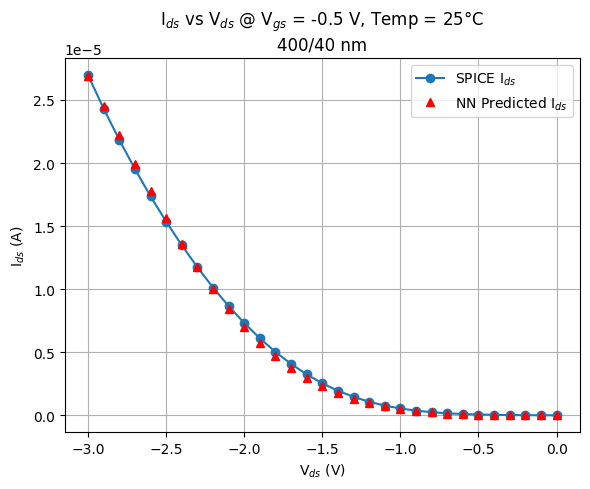

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


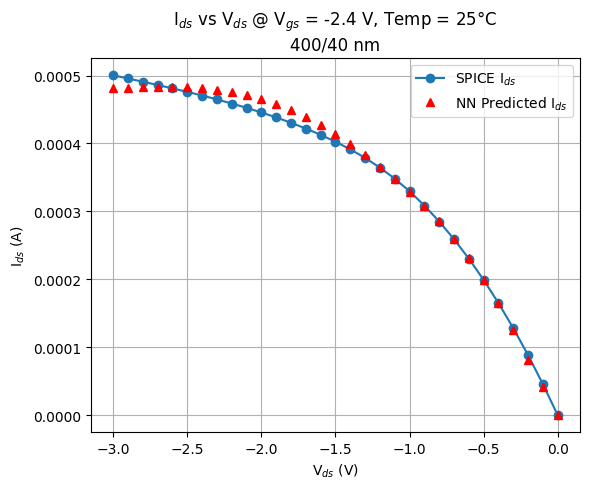

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


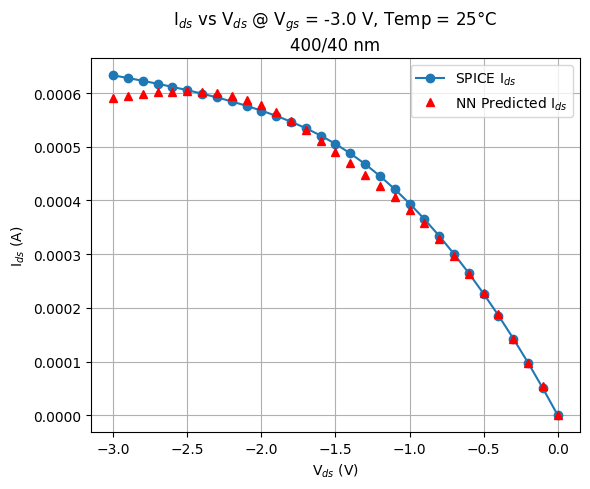

In [52]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# File for Device 1 (nfet_120_40)
df_spice = pd.read_csv("/content/pfet_400_40.csv").sort_values(by=["Vgs(V)", "Vds(V)"])
signature = device_signatures[3]  # PCA vector for Device 1
TEMP_TARGET = 25
VGS_TARGETS = [-0.5, -2.4, -3.0]

for VGS_TARGET in VGS_TARGETS:
    # Filter SPICE data
    mask = (df_spice["Vgs(V)"] == VGS_TARGET) & (df_spice["Temp"] == TEMP_TARGET)
    df_filtered = df_spice[mask].sort_values(by="Vds(V)")

    if df_filtered.empty:
        print(f"⚠️ No SPICE data found for Vgs = {VGS_TARGET} V at {TEMP_TARGET}°C")
        continue

    # Prepare model input
    X_input = [[*signature, row["Vgs(V)"], row["Vds(V)"], row["Temp"]] for _, row in df_filtered.iterrows()]
    X_scaled_input = scaler.transform(X_input)

    # Predict [log_Id, gm_scaled, gd_scaled]
    y_pred = model.predict(X_scaled_input)
    log_Id_pred = y_pred[:, 0]
    Id_pred = 10 ** log_Id_pred

    # Get SPICE values
    Id_spice = df_filtered["Id(A)"].values
    Vds_vals = df_filtered["Vds(V)"].values

    # Plot I_ds vs V_ds
    plt.figure(figsize=(6, 5))
    plt.plot(Vds_vals, Id_spice, "o-", label="SPICE I$_{ds}$")
    # plt.plot(Vds_vals, Id_pred, "s--", label="NN Predicted I$_{ds}$")
    plt.plot(Vds_vals, Id_pred, "^", color='red', label="NN Predicted I$_{ds}$")  # '^' = triangle up


    plt.xlabel("V$_{ds}$ (V)")
    plt.ylabel("I$_{ds}$ (A)")
    plt.title(f"I$_{{ds}}$ vs V$_{{ds}}$ @ V$_{{gs}}$ = {VGS_TARGET} V, Temp = {TEMP_TARGET}°C\n400/40 nm")

    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


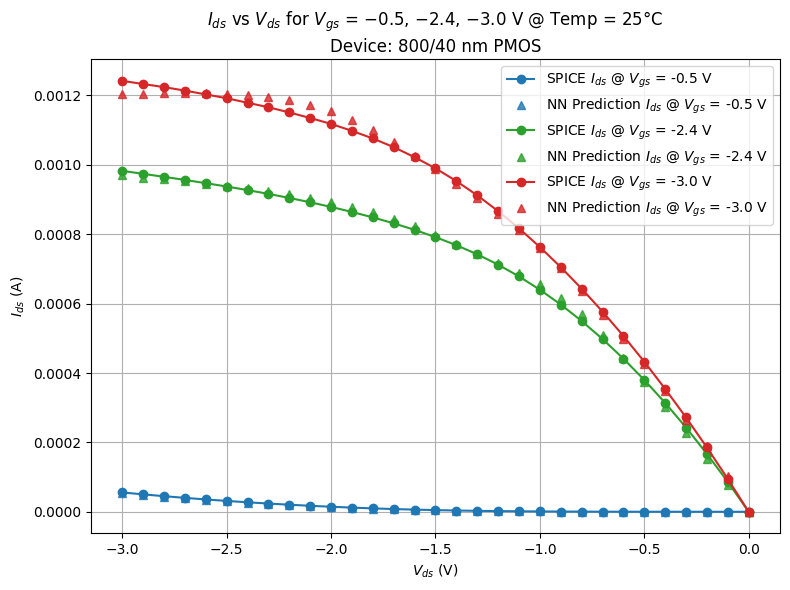

In [53]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# File for PMOS Device 1
df_spice = pd.read_csv("/content/pfet_800_40.csv").sort_values(by=["Vgs(V)", "Vds(V)"])
signature = device_signatures[4]  # PCA vector for pfet_120_40
TEMP_TARGET = 25
VGS_TARGETS = [-0.5, -2.4, -3.0]

# Color map for each Vgs
color_map = {
    -0.5: '#1f77b4',   # blue
    -2.4: '#2ca02c',   # green
    -3.0: '#d62728'    # red
}

# Initialize combined plot
plt.figure(figsize=(8, 6))

for VGS_TARGET in VGS_TARGETS:
    color = color_map[VGS_TARGET]

    # Filter SPICE data
    mask = (df_spice["Vgs(V)"] == VGS_TARGET) & (df_spice["Temp"] == TEMP_TARGET)
    df_filtered = df_spice[mask].sort_values(by="Vds(V)")

    if df_filtered.empty:
        print(f"⚠️ No SPICE data found for Vgs = {VGS_TARGET} V at {TEMP_TARGET}°C")
        continue

    # Prepare model input
    X_input = [[*signature, row["Vgs(V)"], row["Vds(V)"], row["Temp"]] for _, row in df_filtered.iterrows()]
    X_scaled_input = scaler.transform(X_input)
    y_pred = model.predict(X_scaled_input)
    log_Id_pred = y_pred[:, 0]
    Id_pred = 10 ** log_Id_pred

    # Extract values
    Id_spice = df_filtered["Id(A)"].values
    Vds_vals = df_filtered["Vds(V)"].values

    # Plot SPICE and NN with same color, but different markers
    plt.plot(Vds_vals, Id_spice, "o-", color=color, label=f"SPICE $I_{{ds}}$ @ $V_{{gs}}$ = {VGS_TARGET} V")
    plt.plot(Vds_vals, Id_pred, "^", color=color, linestyle="None", alpha=0.8, label=f"NN Prediction $I_{{ds}}$ @ $V_{{gs}}$ = {VGS_TARGET} V")

# Final labels and styling
plt.xlabel("$V_{ds}$ (V)")
plt.ylabel("$I_{ds}$ (A)")
plt.title("$I_{ds}$ vs $V_{ds}$ for $V_{gs}$ = −0.5, −2.4, −3.0 V @ Temp = 25°C\nDevice: 800/40 nm PMOS")
plt.legend(loc='upper right')
plt.grid(True)
plt.tight_layout()
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


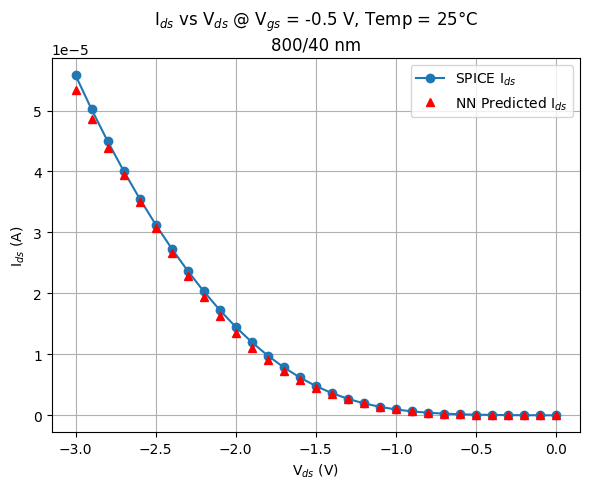

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


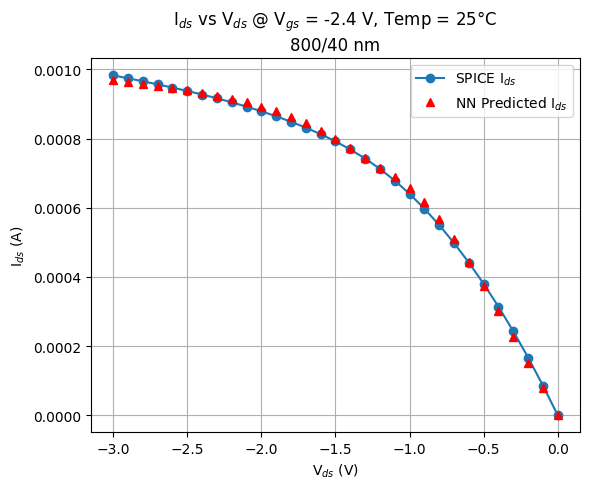

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


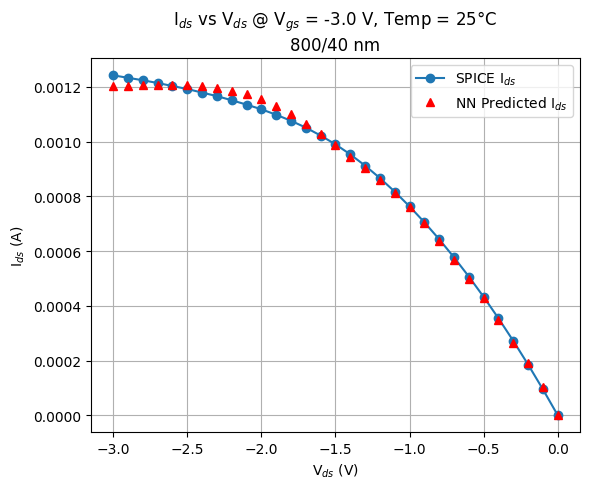

In [54]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# File for Device 1 (nfet_120_40)
df_spice = pd.read_csv("/content/pfet_800_40.csv").sort_values(by=["Vgs(V)", "Vds(V)"])
signature = device_signatures[4]  # PCA vector for Device 1
TEMP_TARGET = 25
VGS_TARGETS = [-0.5, -2.4, -3.0]

for VGS_TARGET in VGS_TARGETS:
    # Filter SPICE data
    mask = (df_spice["Vgs(V)"] == VGS_TARGET) & (df_spice["Temp"] == TEMP_TARGET)
    df_filtered = df_spice[mask].sort_values(by="Vds(V)")

    if df_filtered.empty:
        print(f"⚠️ No SPICE data found for Vgs = {VGS_TARGET} V at {TEMP_TARGET}°C")
        continue

    # Prepare model input
    X_input = [[*signature, row["Vgs(V)"], row["Vds(V)"], row["Temp"]] for _, row in df_filtered.iterrows()]
    X_scaled_input = scaler.transform(X_input)

    # Predict [log_Id, gm_scaled, gd_scaled]
    y_pred = model.predict(X_scaled_input)
    log_Id_pred = y_pred[:, 0]
    Id_pred = 10 ** log_Id_pred

    # Get SPICE values
    Id_spice = df_filtered["Id(A)"].values
    Vds_vals = df_filtered["Vds(V)"].values

    # Plot I_ds vs V_ds
    plt.figure(figsize=(6, 5))
    plt.plot(Vds_vals, Id_spice, "o-", label="SPICE I$_{ds}$")
    # plt.plot(Vds_vals, Id_pred, "s--", label="NN Predicted I$_{ds}$")
    plt.plot(Vds_vals, Id_pred, "^", color='red', label="NN Predicted I$_{ds}$")  # '^' = triangle up


    plt.xlabel("V$_{ds}$ (V)")
    plt.ylabel("I$_{ds}$ (A)")
    plt.title(f"I$_{{ds}}$ vs V$_{{ds}}$ @ V$_{{gs}}$ = {VGS_TARGET} V, Temp = {TEMP_TARGET}°C\n800/40 nm")

    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


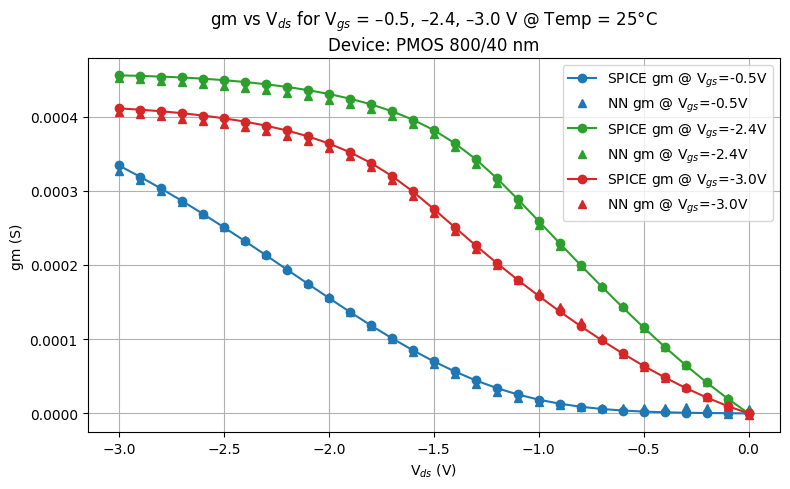

In [55]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

TEMP_TARGET = 25
DEVICE_INDEX = 4  # pfet_200_80.csv
VGS_TARGETS = [-0.5, -2.4, -3.0]
COLOR_MAP = {-0.5: '#1f77b4', -2.4: '#2ca02c', -3.0: '#d62728'}

df_spice = pd.read_csv("pfet_800_40.csv").sort_values(by=["Vgs(V)", "Vds(V)"])
signature = device_signatures[DEVICE_INDEX]

plt.figure(figsize=(8, 5))  # GM plot

for VGS_TARGET in VGS_TARGETS:
    color = COLOR_MAP[VGS_TARGET]
    mask = (df_spice["Vgs(V)"] == VGS_TARGET) & (df_spice["Temp"] == TEMP_TARGET)
    df_filtered = df_spice[mask].sort_values(by="Vds(V)")

    if df_filtered.empty:
        print(f"⚠️ No data for Vgs = {VGS_TARGET} V")
        continue

    X_plot = [[*signature, row["Vgs(V)"], row["Vds(V)"], row["Temp"]] for _, row in df_filtered.iterrows()]
    X_scaled = scaler.transform(X_plot)
    y_pred = model.predict(X_scaled)
    gm_pred_scaled = y_pred[:, 1]
    gm_pred = scaler_gm.inverse_transform(gm_pred_scaled.reshape(-1, 1)).flatten()
    gm_spice = df_filtered["gm"].values
    vds_vals = df_filtered["Vds(V)"].values

    plt.plot(vds_vals, gm_spice, "o-", color=color, label=f"SPICE gm @ V$_{{gs}}$={VGS_TARGET}V")
    plt.plot(vds_vals, gm_pred, "^", color=color, linestyle='None', label=f"NN gm @ V$_{{gs}}$={VGS_TARGET}V")

plt.xlabel("V$_{ds}$ (V)")
plt.ylabel("gm (S)")
plt.title("gm vs V$_{ds}$ for V$_{gs}$ = –0.5, –2.4, –3.0 V @ Temp = 25°C\nDevice: PMOS 800/40 nm")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


<Figure size 800x500 with 0 Axes>

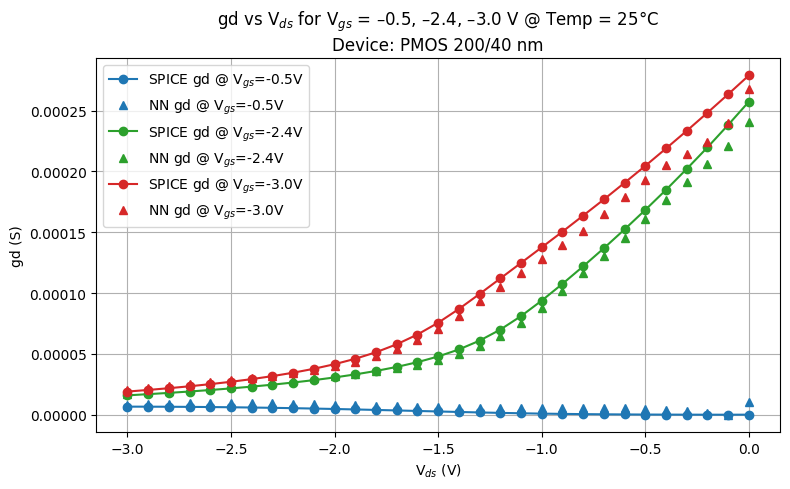

In [56]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

TEMP_TARGET = 25
DEVICE_INDEX = 1 # pfet_200_80.csv
VGS_TARGETS = [-0.5, -2.4, -3.0]
COLOR_MAP = {-0.5: '#1f77b4', -2.4: '#2ca02c', -3.0: '#d62728'}

df_spice = pd.read_csv("pfet_200_40.csv").sort_values(by=["Vgs(V)", "Vds(V)"])
signature = device_signatures[DEVICE_INDEX]

plt.figure(figsize=(8, 5))  # GM plot



plt.figure(figsize=(8, 5))  # GD plot

for VGS_TARGET in VGS_TARGETS:
    color = COLOR_MAP[VGS_TARGET]
    mask = (df_spice["Vgs(V)"] == VGS_TARGET) & (df_spice["Temp"] == TEMP_TARGET)
    df_filtered = df_spice[mask].sort_values(by="Vds(V)")

    if df_filtered.empty:
        continue

    X_plot = [[*signature, row["Vgs(V)"], row["Vds(V)"], row["Temp"]] for _, row in df_filtered.iterrows()]
    X_scaled = scaler.transform(X_plot)
    y_pred = model.predict(X_scaled)
    gd_pred_scaled = y_pred[:, 2]
    gd_pred = scaler_gd.inverse_transform(gd_pred_scaled.reshape(-1, 1)).flatten()
    gd_spice = df_filtered["gds"].values
    vds_vals = df_filtered["Vds(V)"].values

    plt.plot(vds_vals, gd_spice, "o-", color=color, label=f"SPICE gd @ V$_{{gs}}$={VGS_TARGET}V")
    plt.plot(vds_vals, gd_pred, "^", color=color, linestyle='None', label=f"NN gd @ V$_{{gs}}$={VGS_TARGET}V")

plt.xlabel("V$_{ds}$ (V)")
plt.ylabel("gd (S)")
plt.title("gd vs V$_{ds}$ for V$_{gs}$ = –0.5, –2.4, –3.0 V @ Temp = 25°C\nDevice: PMOS 200/40 nm")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


<Figure size 800x500 with 0 Axes>

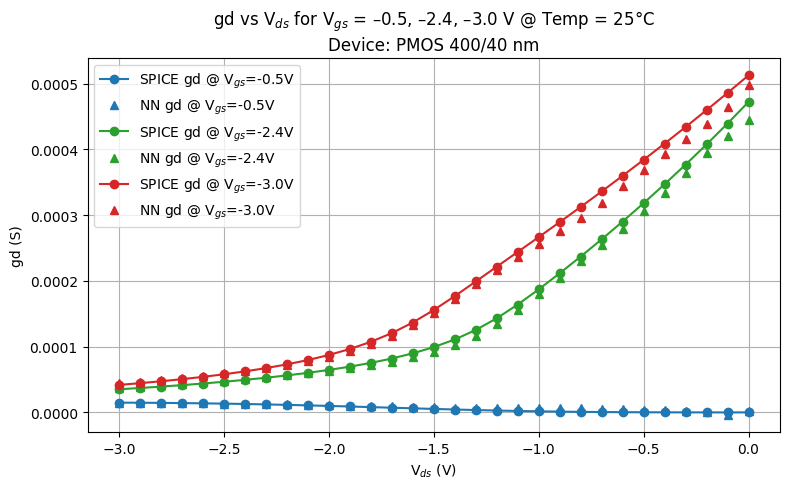

In [57]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

TEMP_TARGET = 25
DEVICE_INDEX = 3 # pfet_200_80.csv
VGS_TARGETS = [-0.5, -2.4, -3.0]
COLOR_MAP = {-0.5: '#1f77b4', -2.4: '#2ca02c', -3.0: '#d62728'}

df_spice = pd.read_csv("pfet_400_40.csv").sort_values(by=["Vgs(V)", "Vds(V)"])
signature = device_signatures[DEVICE_INDEX]

plt.figure(figsize=(8, 5))  # GM plot



plt.figure(figsize=(8, 5))  # GD plot

for VGS_TARGET in VGS_TARGETS:
    color = COLOR_MAP[VGS_TARGET]
    mask = (df_spice["Vgs(V)"] == VGS_TARGET) & (df_spice["Temp"] == TEMP_TARGET)
    df_filtered = df_spice[mask].sort_values(by="Vds(V)")

    if df_filtered.empty:
        continue

    X_plot = [[*signature, row["Vgs(V)"], row["Vds(V)"], row["Temp"]] for _, row in df_filtered.iterrows()]
    X_scaled = scaler.transform(X_plot)
    y_pred = model.predict(X_scaled)
    gd_pred_scaled = y_pred[:, 2]
    gd_pred = scaler_gd.inverse_transform(gd_pred_scaled.reshape(-1, 1)).flatten()
    gd_spice = df_filtered["gds"].values
    vds_vals = df_filtered["Vds(V)"].values

    plt.plot(vds_vals, gd_spice, "o-", color=color, label=f"SPICE gd @ V$_{{gs}}$={VGS_TARGET}V")
    plt.plot(vds_vals, gd_pred, "^", color=color, linestyle='None', label=f"NN gd @ V$_{{gs}}$={VGS_TARGET}V")

plt.xlabel("V$_{ds}$ (V)")
plt.ylabel("gd (S)")
plt.title("gd vs V$_{ds}$ for V$_{gs}$ = –0.5, –2.4, –3.0 V @ Temp = 25°C\nDevice: PMOS 400/40 nm")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


<Figure size 800x500 with 0 Axes>

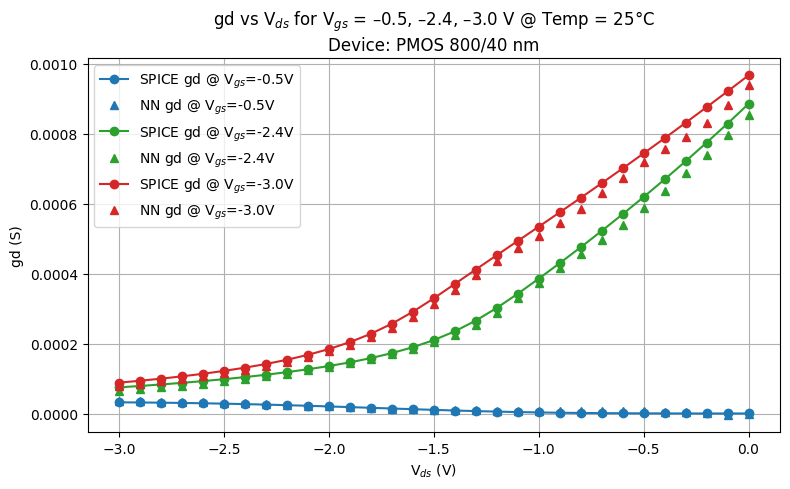

In [58]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

TEMP_TARGET = 25
DEVICE_INDEX = 4 # pfet_200_80.csv
VGS_TARGETS = [-0.5, -2.4, -3.0]
COLOR_MAP = {-0.5: '#1f77b4', -2.4: '#2ca02c', -3.0: '#d62728'}

df_spice = pd.read_csv("pfet_800_40.csv").sort_values(by=["Vgs(V)", "Vds(V)"])
signature = device_signatures[DEVICE_INDEX]

plt.figure(figsize=(8, 5))  # GM plot



plt.figure(figsize=(8, 5))  # GD plot

for VGS_TARGET in VGS_TARGETS:
    color = COLOR_MAP[VGS_TARGET]
    mask = (df_spice["Vgs(V)"] == VGS_TARGET) & (df_spice["Temp"] == TEMP_TARGET)
    df_filtered = df_spice[mask].sort_values(by="Vds(V)")

    if df_filtered.empty:
        continue

    X_plot = [[*signature, row["Vgs(V)"], row["Vds(V)"], row["Temp"]] for _, row in df_filtered.iterrows()]
    X_scaled = scaler.transform(X_plot)
    y_pred = model.predict(X_scaled)
    gd_pred_scaled = y_pred[:, 2]
    gd_pred = scaler_gd.inverse_transform(gd_pred_scaled.reshape(-1, 1)).flatten()
    gd_spice = df_filtered["gds"].values
    vds_vals = df_filtered["Vds(V)"].values

    plt.plot(vds_vals, gd_spice, "o-", color=color, label=f"SPICE gd @ V$_{{gs}}$={VGS_TARGET}V")
    plt.plot(vds_vals, gd_pred, "^", color=color, linestyle='None', label=f"NN gd @ V$_{{gs}}$={VGS_TARGET}V")

plt.xlabel("V$_{ds}$ (V)")
plt.ylabel("gd (S)")
plt.title("gd vs V$_{ds}$ for V$_{gs}$ = –0.5, –2.4, –3.0 V @ Temp = 25°C\nDevice: PMOS 800/40 nm")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


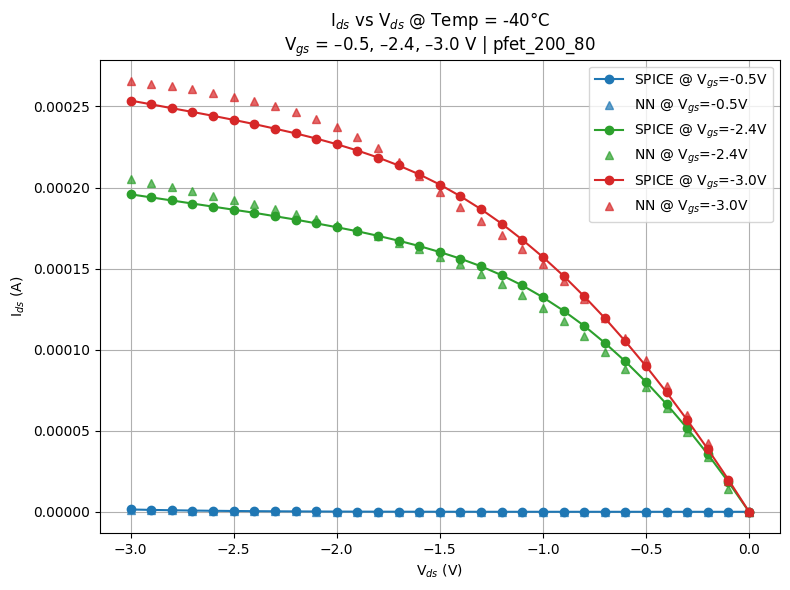

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


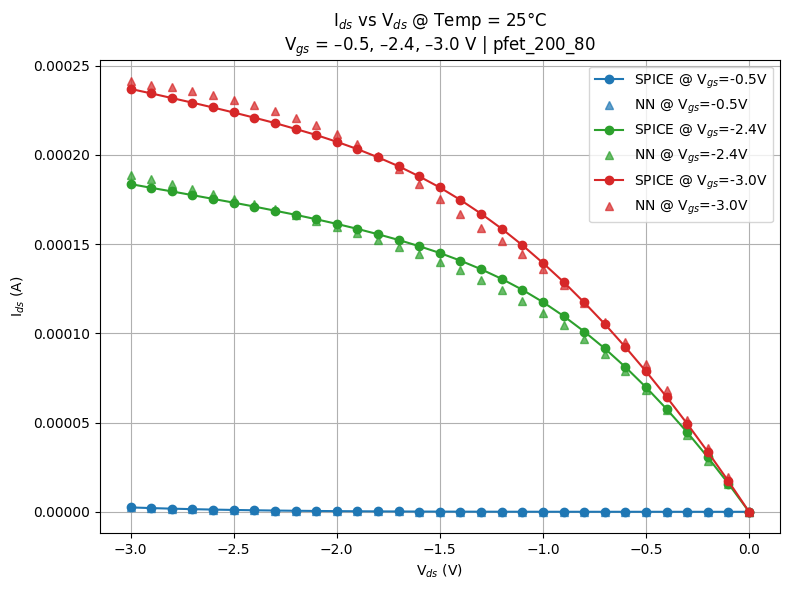

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


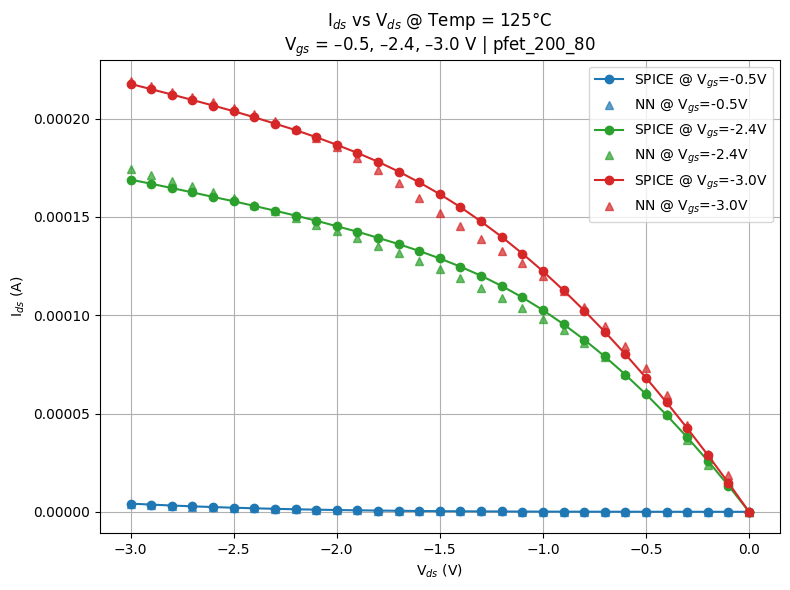

In [59]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Configuration
DEVICE_INDEX = 2  # for pfet_200_80.csv
VGS_TARGETS = [-0.5, -2.4, -3.0]
TEMP_TARGETS = [-40, 25, 125]
COLOR_MAP = {-0.5: '#1f77b4', -2.4: '#2ca02c', -3.0: '#d62728'}

# Load data
df_spice = pd.read_csv("pfet_200_80.csv").sort_values(by=["Temp", "Vgs(V)", "Vds(V)"])
signature = device_signatures[DEVICE_INDEX]

# Loop over temperatures
for TEMP in TEMP_TARGETS:
    plt.figure(figsize=(8, 6))
    for VGS_TARGET in VGS_TARGETS:
        color = COLOR_MAP[VGS_TARGET]
        mask = (df_spice["Vgs(V)"] == VGS_TARGET) & (df_spice["Temp"] == TEMP)
        df_filtered = df_spice[mask].sort_values(by="Vds(V)")

        if df_filtered.empty:
            print(f"⚠️ No data for Vgs = {VGS_TARGET} V, Temp = {TEMP}°C")
            continue

        # NN prediction
        X_input = [[*signature, row["Vgs(V)"], row["Vds(V)"], row["Temp"]] for _, row in df_filtered.iterrows()]
        X_scaled = scaler.transform(X_input)
        y_pred = model.predict(X_scaled)
        log_Id_pred = y_pred[:, 0]
        Id_pred = 10 ** log_Id_pred

        # SPICE
        Id_spice = df_filtered["Id(A)"].values
        Vds_vals = df_filtered["Vds(V)"].values

        # Plot both
        plt.plot(Vds_vals, Id_spice, "o-", color=color, label=f"SPICE @ V$_{{gs}}$={VGS_TARGET}V")
        plt.plot(Vds_vals, Id_pred, "^", color=color, linestyle='None', alpha=0.7, label=f"NN @ V$_{{gs}}$={VGS_TARGET}V")

    plt.xlabel("V$_{ds}$ (V)")
    plt.ylabel("I$_{ds}$ (A)")
    plt.title(f"I$_{{ds}}$ vs V$_{{ds}}$ @ Temp = {TEMP}°C\nV$_{{gs}}$ = –0.5, –2.4, –3.0 V | pfet_200_80")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


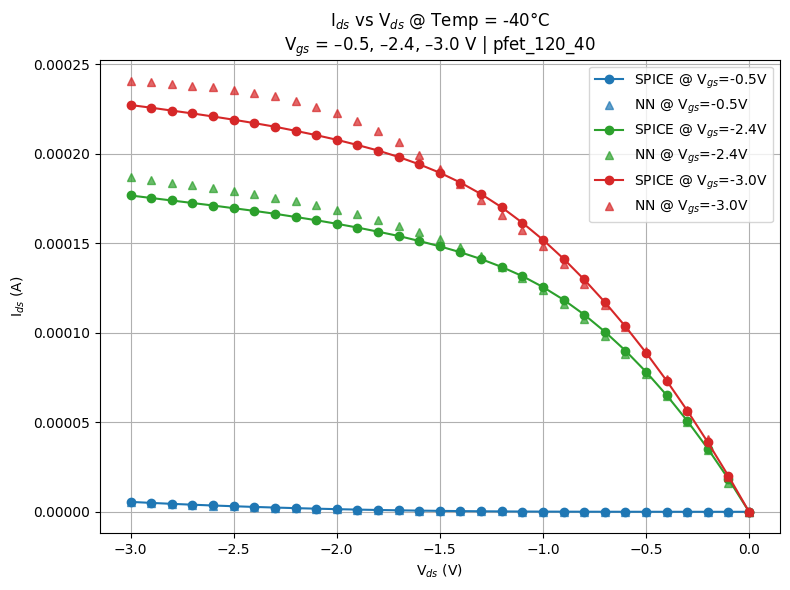

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


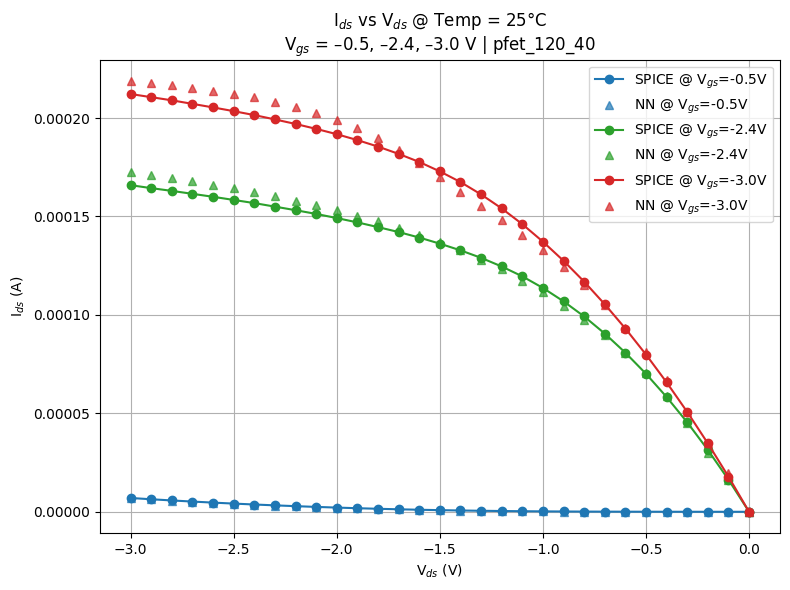

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


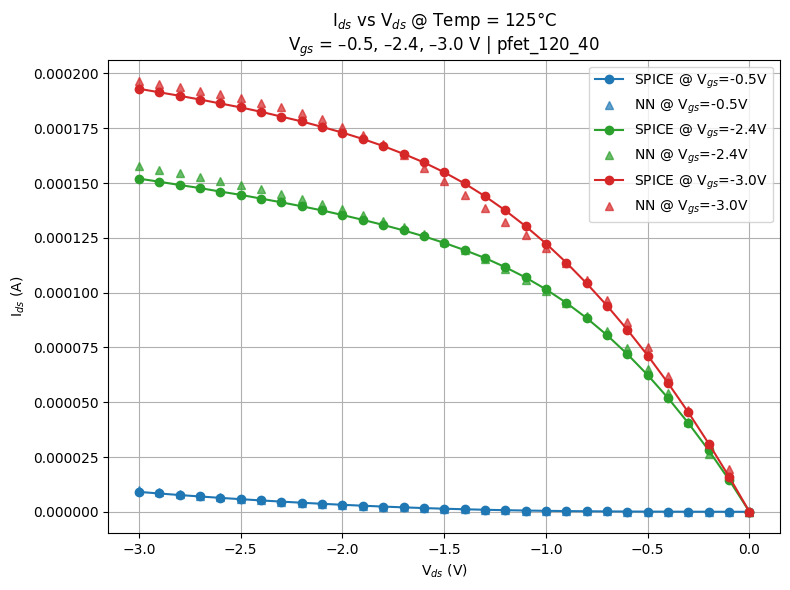

In [60]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Configuration
DEVICE_INDEX = 0  # for pfet_200_80.csv
VGS_TARGETS = [-0.5, -2.4, -3.0]
TEMP_TARGETS = [-40, 25, 125]
COLOR_MAP = {-0.5: '#1f77b4', -2.4: '#2ca02c', -3.0: '#d62728'}

# Load data
df_spice = pd.read_csv("pfet_120_40.csv").sort_values(by=["Temp", "Vgs(V)", "Vds(V)"])
signature = device_signatures[DEVICE_INDEX]

# Loop over temperatures
for TEMP in TEMP_TARGETS:
    plt.figure(figsize=(8, 6))
    for VGS_TARGET in VGS_TARGETS:
        color = COLOR_MAP[VGS_TARGET]
        mask = (df_spice["Vgs(V)"] == VGS_TARGET) & (df_spice["Temp"] == TEMP)
        df_filtered = df_spice[mask].sort_values(by="Vds(V)")

        if df_filtered.empty:
            print(f"⚠️ No data for Vgs = {VGS_TARGET} V, Temp = {TEMP}°C")
            continue

        # NN prediction
        X_input = [[*signature, row["Vgs(V)"], row["Vds(V)"], row["Temp"]] for _, row in df_filtered.iterrows()]
        X_scaled = scaler.transform(X_input)
        y_pred = model.predict(X_scaled)
        log_Id_pred = y_pred[:, 0]
        Id_pred = 10 ** log_Id_pred

        # SPICE
        Id_spice = df_filtered["Id(A)"].values
        Vds_vals = df_filtered["Vds(V)"].values

        # Plot both
        plt.plot(Vds_vals, Id_spice, "o-", color=color, label=f"SPICE @ V$_{{gs}}$={VGS_TARGET}V")
        plt.plot(Vds_vals, Id_pred, "^", color=color, linestyle='None', alpha=0.7, label=f"NN @ V$_{{gs}}$={VGS_TARGET}V")

    plt.xlabel("V$_{ds}$ (V)")
    plt.ylabel("I$_{ds}$ (A)")
    plt.title(f"I$_{{ds}}$ vs V$_{{ds}}$ @ Temp = {TEMP}°C\nV$_{{gs}}$ = –0.5, –2.4, –3.0 V | pfet_120_40")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


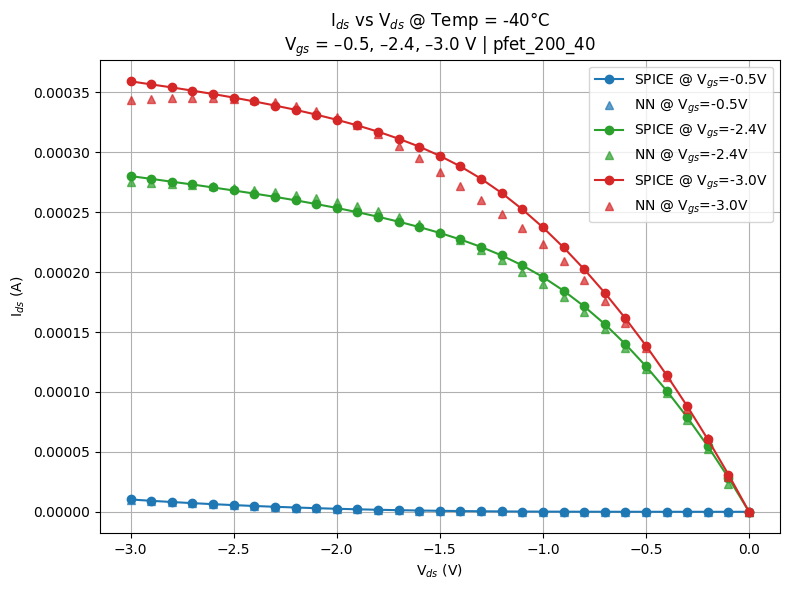

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


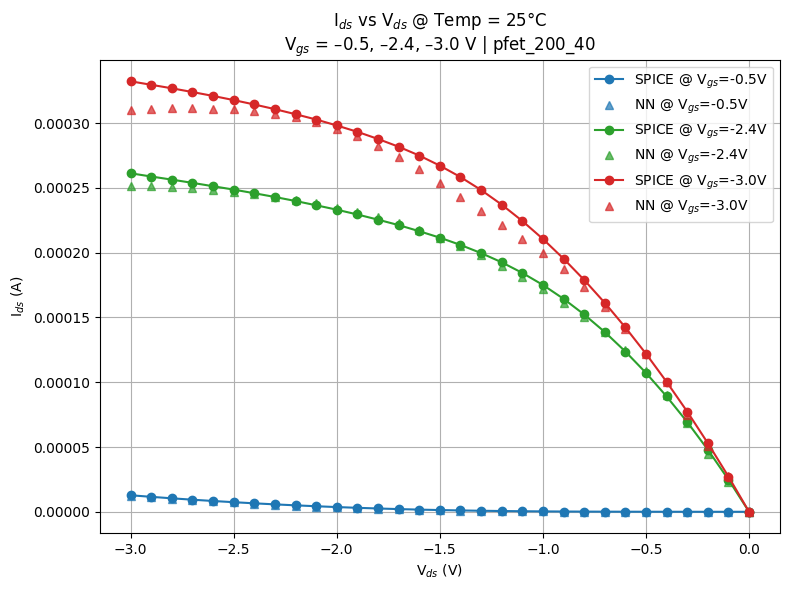

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


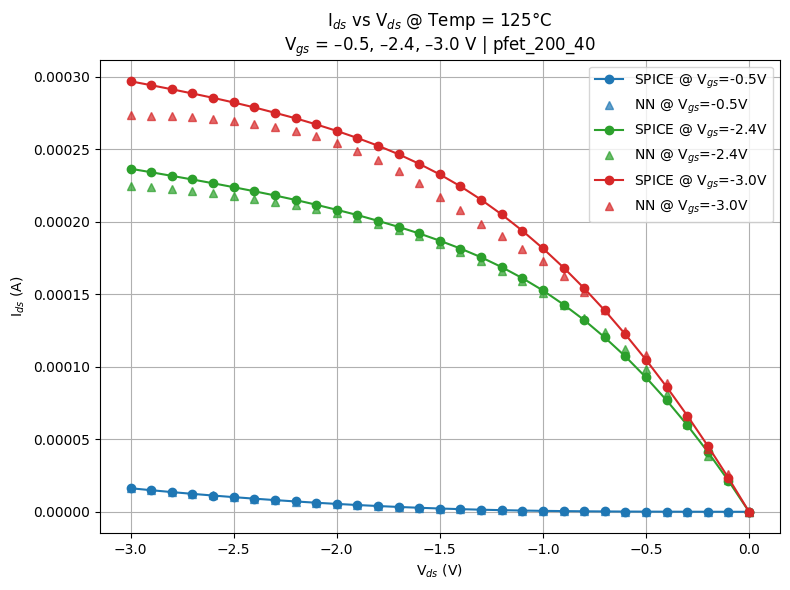

In [63]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Configuration
DEVICE_INDEX = 1  # for pfet_200_80.csv
VGS_TARGETS = [-0.5, -2.4, -3.0]
TEMP_TARGETS = [-40, 25, 125]
COLOR_MAP = {-0.5: '#1f77b4', -2.4: '#2ca02c', -3.0: '#d62728'}

# Load data
df_spice = pd.read_csv("pfet_200_40.csv").sort_values(by=["Temp", "Vgs(V)", "Vds(V)"])
signature = device_signatures[DEVICE_INDEX]

# Loop over temperatures
for TEMP in TEMP_TARGETS:
    plt.figure(figsize=(8, 6))
    for VGS_TARGET in VGS_TARGETS:
        color = COLOR_MAP[VGS_TARGET]
        mask = (df_spice["Vgs(V)"] == VGS_TARGET) & (df_spice["Temp"] == TEMP)
        df_filtered = df_spice[mask].sort_values(by="Vds(V)")

        if df_filtered.empty:
            print(f"⚠️ No data for Vgs = {VGS_TARGET} V, Temp = {TEMP}°C")
            continue

        # NN prediction
        X_input = [[*signature, row["Vgs(V)"], row["Vds(V)"], row["Temp"]] for _, row in df_filtered.iterrows()]
        X_scaled = scaler.transform(X_input)
        y_pred = model.predict(X_scaled)
        log_Id_pred = y_pred[:, 0]
        Id_pred = 10 ** log_Id_pred

        # SPICE
        Id_spice = df_filtered["Id(A)"].values
        Vds_vals = df_filtered["Vds(V)"].values

        # Plot both
        plt.plot(Vds_vals, Id_spice, "o-", color=color, label=f"SPICE @ V$_{{gs}}$={VGS_TARGET}V")
        plt.plot(Vds_vals, Id_pred, "^", color=color, linestyle='None', alpha=0.7, label=f"NN @ V$_{{gs}}$={VGS_TARGET}V")

    plt.xlabel("V$_{ds}$ (V)")
    plt.ylabel("I$_{ds}$ (A)")
    plt.title(f"I$_{{ds}}$ vs V$_{{ds}}$ @ Temp = {TEMP}°C\nV$_{{gs}}$ = –0.5, –2.4, –3.0 V | pfet_200_40")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


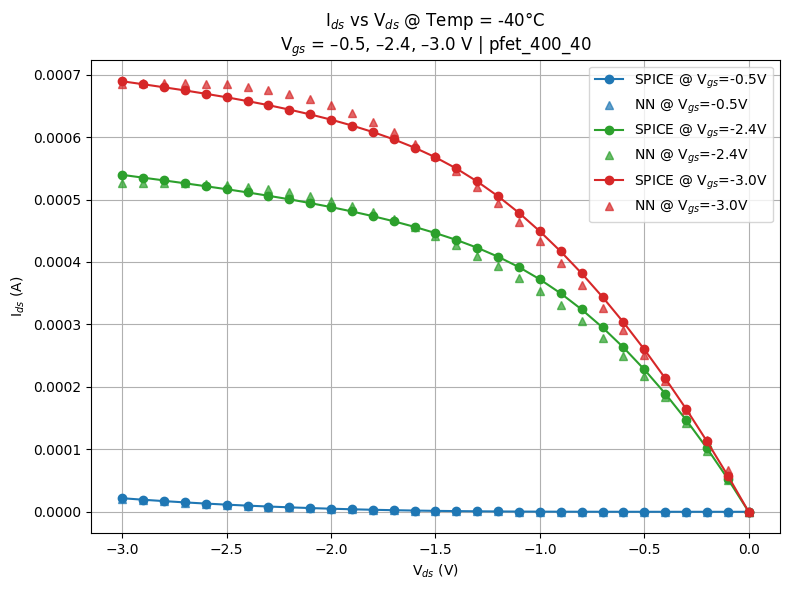

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


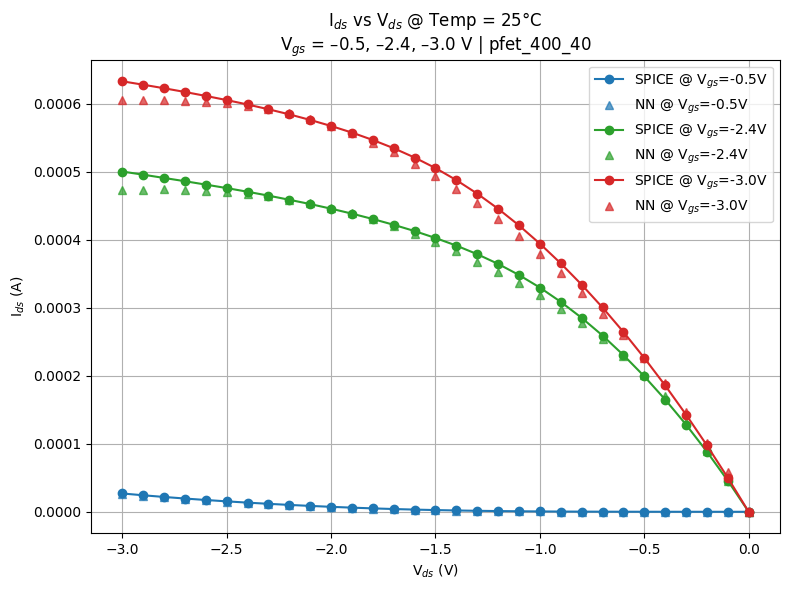

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


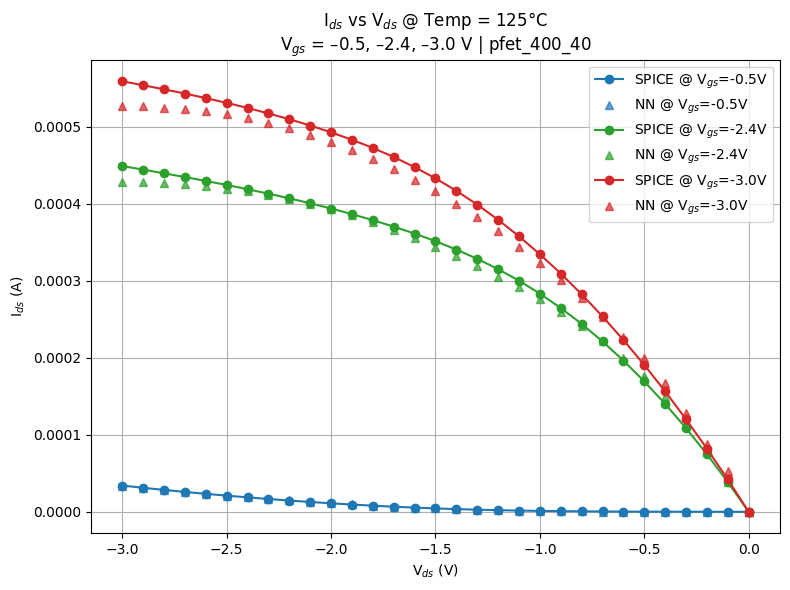

In [32]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Configuration
DEVICE_INDEX = 3  # for pfet_200_80.csv
VGS_TARGETS = [-0.5, -2.4, -3.0]
TEMP_TARGETS = [-40, 25, 125]
COLOR_MAP = {-0.5: '#1f77b4', -2.4: '#2ca02c', -3.0: '#d62728'}

# Load data
df_spice = pd.read_csv("pfet_400_40.csv").sort_values(by=["Temp", "Vgs(V)", "Vds(V)"])
signature = device_signatures[DEVICE_INDEX]

# Loop over temperatures
for TEMP in TEMP_TARGETS:
    plt.figure(figsize=(8, 6))
    for VGS_TARGET in VGS_TARGETS:
        color = COLOR_MAP[VGS_TARGET]
        mask = (df_spice["Vgs(V)"] == VGS_TARGET) & (df_spice["Temp"] == TEMP)
        df_filtered = df_spice[mask].sort_values(by="Vds(V)")

        if df_filtered.empty:
            print(f"⚠️ No data for Vgs = {VGS_TARGET} V, Temp = {TEMP}°C")
            continue

        # NN prediction
        X_input = [[*signature, row["Vgs(V)"], row["Vds(V)"], row["Temp"]] for _, row in df_filtered.iterrows()]
        X_scaled = scaler.transform(X_input)
        y_pred = model.predict(X_scaled)
        log_Id_pred = y_pred[:, 0]
        Id_pred = 10 ** log_Id_pred

        # SPICE
        Id_spice = df_filtered["Id(A)"].values
        Vds_vals = df_filtered["Vds(V)"].values

        # Plot both
        plt.plot(Vds_vals, Id_spice, "o-", color=color, label=f"SPICE @ V$_{{gs}}$={VGS_TARGET}V")
        plt.plot(Vds_vals, Id_pred, "^", color=color, linestyle='None', alpha=0.7, label=f"NN @ V$_{{gs}}$={VGS_TARGET}V")

    plt.xlabel("V$_{ds}$ (V)")
    plt.ylabel("I$_{ds}$ (A)")
    plt.title(f"I$_{{ds}}$ vs V$_{{ds}}$ @ Temp = {TEMP}°C\nV$_{{gs}}$ = –0.5, –2.4, –3.0 V | pfet_400_40")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


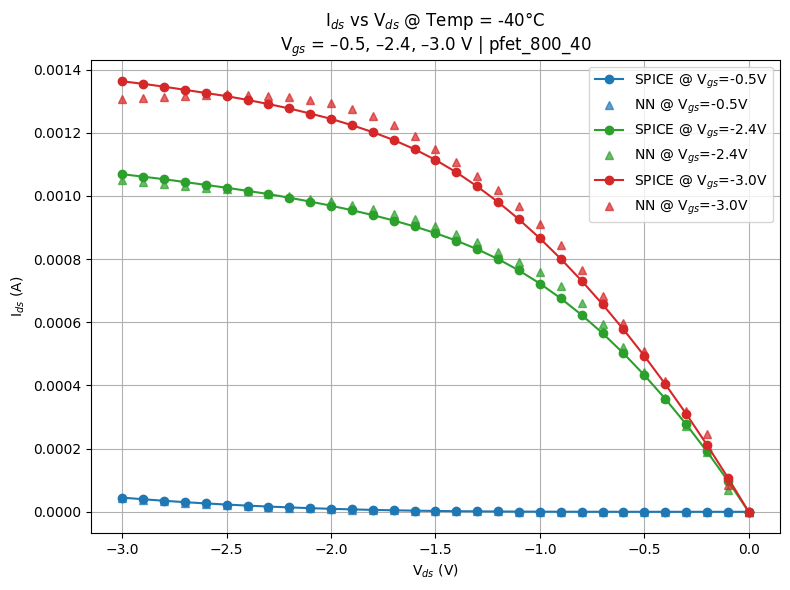

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


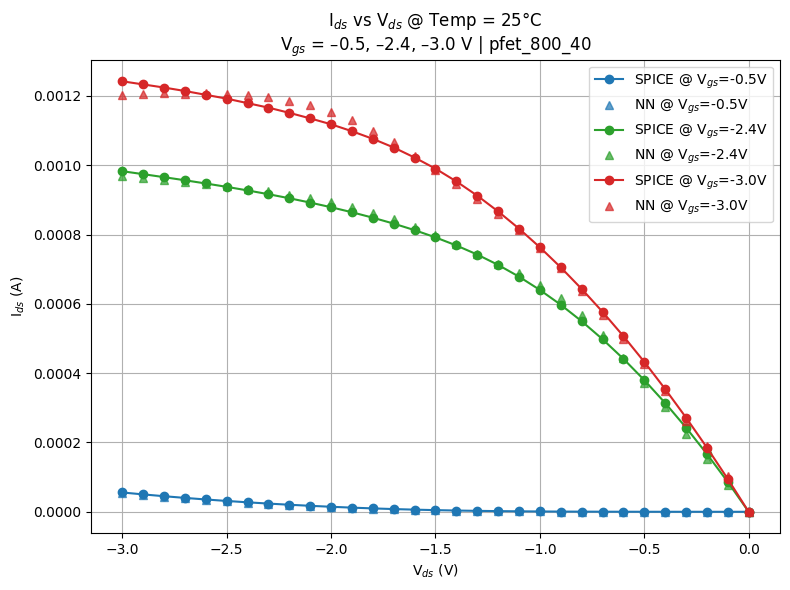

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


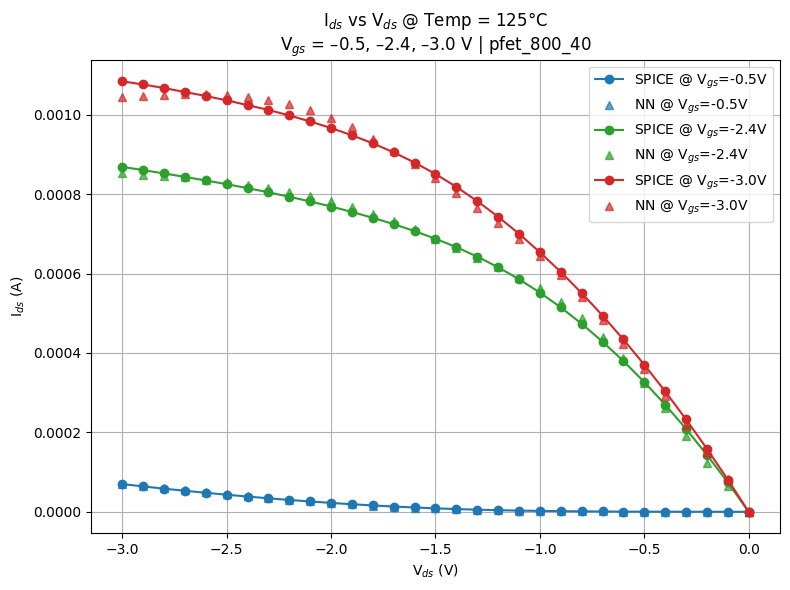

In [64]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Configuration
DEVICE_INDEX = 4  # for pfet_200_80.csv
VGS_TARGETS = [-0.5, -2.4, -3.0]
TEMP_TARGETS = [-40, 25, 125]
COLOR_MAP = {-0.5: '#1f77b4', -2.4: '#2ca02c', -3.0: '#d62728'}

# Load data
df_spice = pd.read_csv("pfet_800_40.csv").sort_values(by=["Temp", "Vgs(V)", "Vds(V)"])
signature = device_signatures[DEVICE_INDEX]

# Loop over temperatures
for TEMP in TEMP_TARGETS:
    plt.figure(figsize=(8, 6))
    for VGS_TARGET in VGS_TARGETS:
        color = COLOR_MAP[VGS_TARGET]
        mask = (df_spice["Vgs(V)"] == VGS_TARGET) & (df_spice["Temp"] == TEMP)
        df_filtered = df_spice[mask].sort_values(by="Vds(V)")

        if df_filtered.empty:
            print(f"⚠️ No data for Vgs = {VGS_TARGET} V, Temp = {TEMP}°C")
            continue

        # NN prediction
        X_input = [[*signature, row["Vgs(V)"], row["Vds(V)"], row["Temp"]] for _, row in df_filtered.iterrows()]
        X_scaled = scaler.transform(X_input)
        y_pred = model.predict(X_scaled)
        log_Id_pred = y_pred[:, 0]
        Id_pred = 10 ** log_Id_pred

        # SPICE
        Id_spice = df_filtered["Id(A)"].values
        Vds_vals = df_filtered["Vds(V)"].values

        # Plot both
        plt.plot(Vds_vals, Id_spice, "o-", color=color, label=f"SPICE @ V$_{{gs}}$={VGS_TARGET}V")
        plt.plot(Vds_vals, Id_pred, "^", color=color, linestyle='None', alpha=0.7, label=f"NN @ V$_{{gs}}$={VGS_TARGET}V")

    plt.xlabel("V$_{ds}$ (V)")
    plt.ylabel("I$_{ds}$ (A)")
    plt.title(f"I$_{{ds}}$ vs V$_{{ds}}$ @ Temp = {TEMP}°C\nV$_{{gs}}$ = –0.5, –2.4, –3.0 V | pfet_800_40")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


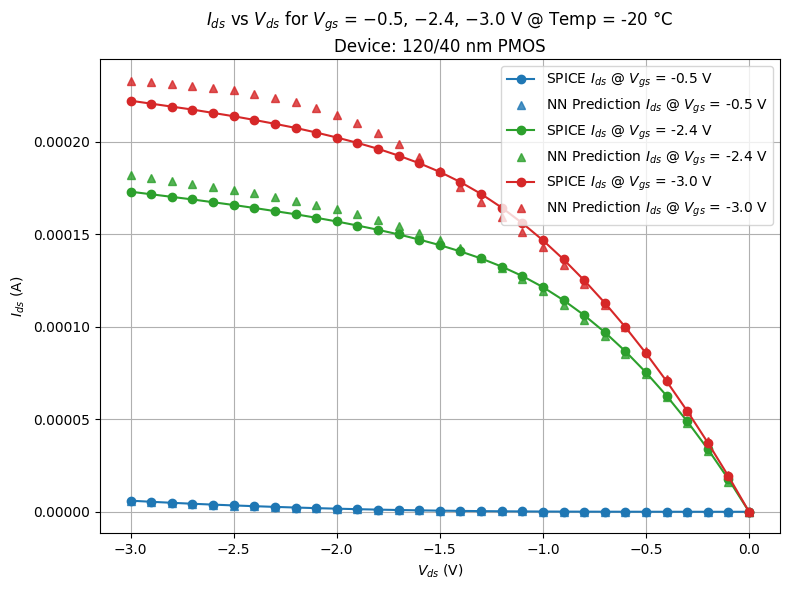

In [65]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# File for PMOS Device 1
df_spice = pd.read_csv("/content/pfet_120_40__-20_80.csv").sort_values(by=["Vgs(V)", "Vds(V)"])
signature = device_signatures[0]  # PCA vector for pfet_120_40
TEMP_TARGET = -20
VGS_TARGETS = [-0.5, -2.4, -3.0]

# Color map for each Vgs
color_map = {
    -0.5: '#1f77b4',   # blue
    -2.4: '#2ca02c',   # green
    -3.0: '#d62728'    # red
}

# Initialize combined plot
plt.figure(figsize=(8, 6))

for VGS_TARGET in VGS_TARGETS:
    color = color_map[VGS_TARGET]

    # Filter SPICE data
    mask = (df_spice["Vgs(V)"] == VGS_TARGET) & (df_spice["Temp"] == TEMP_TARGET)
    df_filtered = df_spice[mask].sort_values(by="Vds(V)")

    if df_filtered.empty:
        print(f"⚠️ No SPICE data found for Vgs = {VGS_TARGET} V at {TEMP_TARGET}°C")
        continue

    # Prepare model input
    X_input = [[*signature, row["Vgs(V)"], row["Vds(V)"], row["Temp"]] for _, row in df_filtered.iterrows()]
    X_scaled_input = scaler.transform(X_input)
    y_pred = model.predict(X_scaled_input)
    log_Id_pred = y_pred[:, 0]
    Id_pred = 10 ** log_Id_pred

    # Extract values
    Id_spice = df_filtered["Id(A)"].values
    Vds_vals = df_filtered["Vds(V)"].values

    # Plot SPICE and NN with same color, but different markers
    plt.plot(Vds_vals, Id_spice, "o-", color=color, label=f"SPICE $I_{{ds}}$ @ $V_{{gs}}$ = {VGS_TARGET} V")
    plt.plot(Vds_vals, Id_pred, "^", color=color, linestyle="None", alpha=0.8, label=f"NN Prediction $I_{{ds}}$ @ $V_{{gs}}$ = {VGS_TARGET} V")

# Final labels and styling
plt.xlabel("$V_{ds}$ (V)")
plt.ylabel("$I_{ds}$ (A)")
plt.title(f"$I_{{ds}}$ vs $V_{{ds}}$ for $V_{{gs}}$ = −0.5, −2.4, −3.0 V @ Temp = {TEMP_TARGET} °C\nDevice: 120/40 nm PMOS")
plt.legend(loc="upper right")
plt.grid(True)
plt.tight_layout()
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


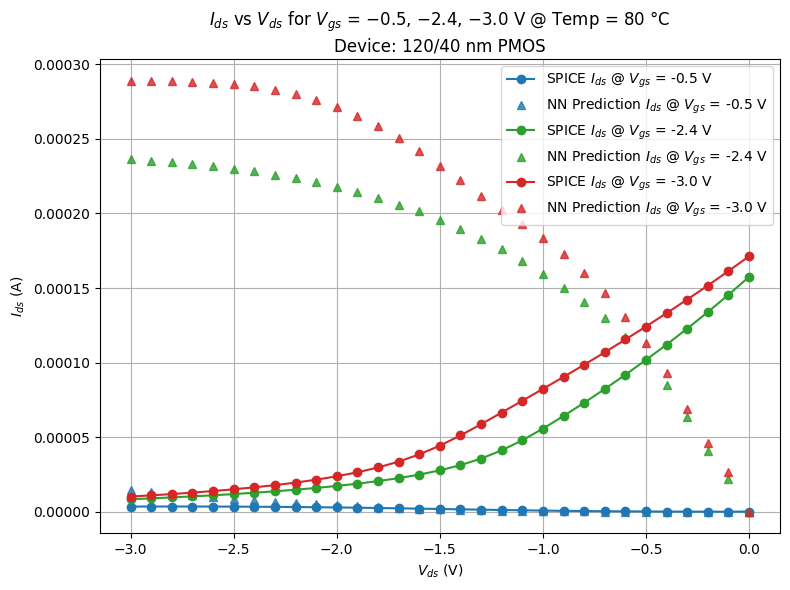

In [66]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# File for PMOS Device 1
df_spice = pd.read_csv("/content/pfet_120_40__-20_80.csv").sort_values(by=["Vgs(V)", "Vds(V)"])
signature = device_signatures[1]  # PCA vector for pfet_120_40
TEMP_TARGET = 80
VGS_TARGETS = [-0.5, -2.4, -3.0]

# Color map for each Vgs
color_map = {
    -0.5: '#1f77b4',   # blue
    -2.4: '#2ca02c',   # green
    -3.0: '#d62728'    # red
}

# Initialize combined plot
plt.figure(figsize=(8, 6))

for VGS_TARGET in VGS_TARGETS:
    color = color_map[VGS_TARGET]

    # Filter SPICE data
    mask = (df_spice["Vgs(V)"] == VGS_TARGET) & (df_spice["Temp"] == TEMP_TARGET)
    df_filtered = df_spice[mask].sort_values(by="Vds(V)")

    if df_filtered.empty:
        print(f"⚠️ No SPICE data found for Vgs = {VGS_TARGET} V at {TEMP_TARGET}°C")
        continue

    # Prepare model input
    X_input = [[*signature, row["Vgs(V)"], row["Vds(V)"], row["Temp"]] for _, row in df_filtered.iterrows()]
    X_scaled_input = scaler.transform(X_input)
    y_pred = model.predict(X_scaled_input)
    log_Id_pred = y_pred[:, 0]
    Id_pred = 10 ** log_Id_pred

    # Extract values
    Id_spice = df_filtered["Id(A)"].values
    Vds_vals = df_filtered["Vds(V)"].values

    # Plot SPICE and NN with same color, but different markers
    plt.plot(Vds_vals, Id_spice, "o-", color=color, label=f"SPICE $I_{{ds}}$ @ $V_{{gs}}$ = {VGS_TARGET} V")
    plt.plot(Vds_vals, Id_pred, "^", color=color, linestyle="None", alpha=0.8, label=f"NN Prediction $I_{{ds}}$ @ $V_{{gs}}$ = {VGS_TARGET} V")

# Final labels and styling
plt.xlabel("$V_{ds}$ (V)")
plt.ylabel("$I_{ds}$ (A)")
plt.title(f"$I_{{ds}}$ vs $V_{{ds}}$ for $V_{{gs}}$ = −0.5, −2.4, −3.0 V @ Temp = {TEMP_TARGET} °C\nDevice: 120/40 nm PMOS")
plt.legend(loc="upper right")
plt.grid(True)
plt.tight_layout()
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


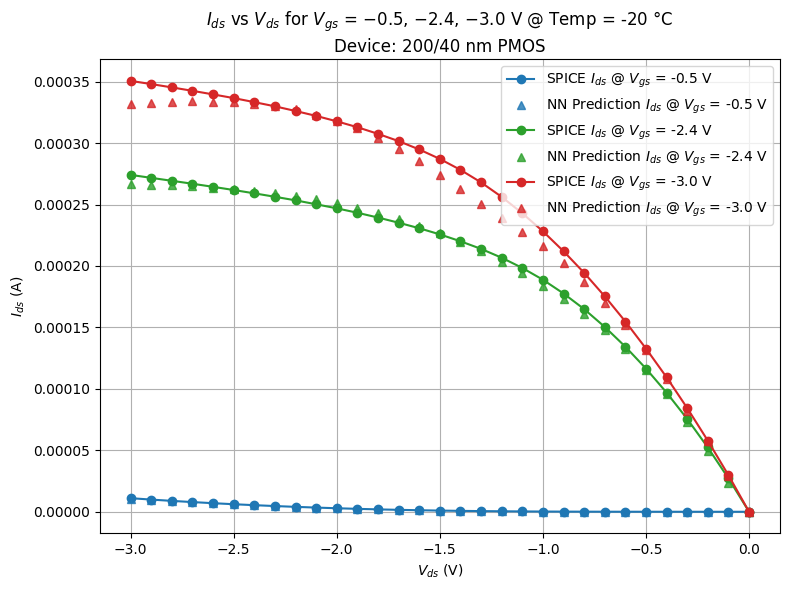

In [67]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# File for PMOS Device 1
df_spice = pd.read_csv("/content/pfet_200_40_-20_80.csv").sort_values(by=["Vgs(V)", "Vds(V)"])
signature = device_signatures[1]  # PCA vector for pfet_120_40
TEMP_TARGET = -20
VGS_TARGETS = [-0.5, -2.4, -3.0]

# Color map for each Vgs
color_map = {
    -0.5: '#1f77b4',   # blue
    -2.4: '#2ca02c',   # green
    -3.0: '#d62728'    # red
}

# Initialize combined plot
plt.figure(figsize=(8, 6))

for VGS_TARGET in VGS_TARGETS:
    color = color_map[VGS_TARGET]

    # Filter SPICE data
    mask = (df_spice["Vgs(V)"] == VGS_TARGET) & (df_spice["Temp"] == TEMP_TARGET)
    df_filtered = df_spice[mask].sort_values(by="Vds(V)")

    if df_filtered.empty:
        print(f"⚠️ No SPICE data found for Vgs = {VGS_TARGET} V at {TEMP_TARGET}°C")
        continue

    # Prepare model input
    X_input = [[*signature, row["Vgs(V)"], row["Vds(V)"], row["Temp"]] for _, row in df_filtered.iterrows()]
    X_scaled_input = scaler.transform(X_input)
    y_pred = model.predict(X_scaled_input)
    log_Id_pred = y_pred[:, 0]
    Id_pred = 10 ** log_Id_pred

    # Extract values
    Id_spice = df_filtered["Id(A)"].values
    Vds_vals = df_filtered["Vds(V)"].values

    # Plot SPICE and NN with same color, but different markers
    plt.plot(Vds_vals, Id_spice, "o-", color=color, label=f"SPICE $I_{{ds}}$ @ $V_{{gs}}$ = {VGS_TARGET} V")
    plt.plot(Vds_vals, Id_pred, "^", color=color, linestyle="None", alpha=0.8, label=f"NN Prediction $I_{{ds}}$ @ $V_{{gs}}$ = {VGS_TARGET} V")

# Final labels and styling
plt.xlabel("$V_{ds}$ (V)")
plt.ylabel("$I_{ds}$ (A)")
plt.title(f"$I_{{ds}}$ vs $V_{{ds}}$ for $V_{{gs}}$ = −0.5, −2.4, −3.0 V @ Temp = {TEMP_TARGET} °C\nDevice: 200/40 nm PMOS")
plt.legend(loc="upper right")
plt.grid(True)
plt.tight_layout()
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


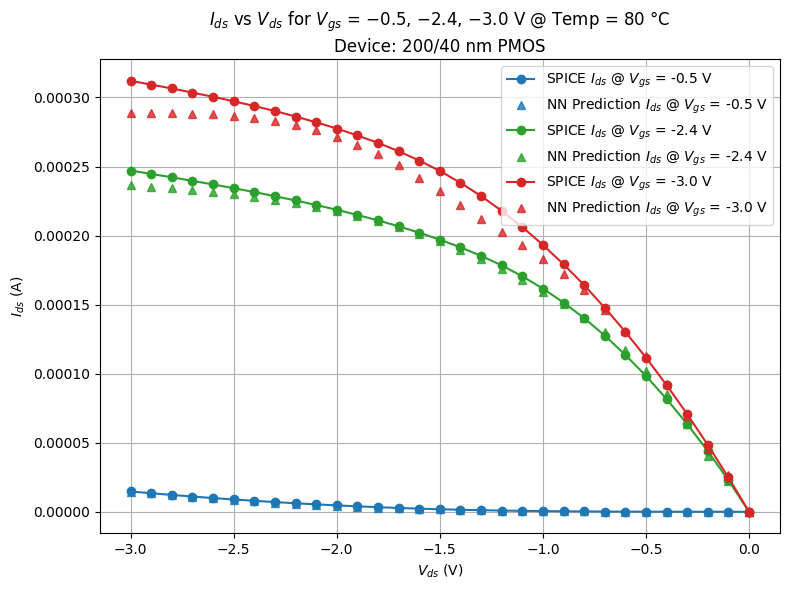

In [68]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# File for PMOS Device 1
df_spice = pd.read_csv("/content/pfet_200_40_-20_80.csv").sort_values(by=["Vgs(V)", "Vds(V)"])
signature = device_signatures[1]  # PCA vector for pfet_120_40
TEMP_TARGET = 80
VGS_TARGETS = [-0.5, -2.4, -3.0]

# Color map for each Vgs
color_map = {
    -0.5: '#1f77b4',   # blue
    -2.4: '#2ca02c',   # green
    -3.0: '#d62728'    # red
}

# Initialize combined plot
plt.figure(figsize=(8, 6))

for VGS_TARGET in VGS_TARGETS:
    color = color_map[VGS_TARGET]

    # Filter SPICE data
    mask = (df_spice["Vgs(V)"] == VGS_TARGET) & (df_spice["Temp"] == TEMP_TARGET)
    df_filtered = df_spice[mask].sort_values(by="Vds(V)")

    if df_filtered.empty:
        print(f"⚠️ No SPICE data found for Vgs = {VGS_TARGET} V at {TEMP_TARGET}°C")
        continue

    # Prepare model input
    X_input = [[*signature, row["Vgs(V)"], row["Vds(V)"], row["Temp"]] for _, row in df_filtered.iterrows()]
    X_scaled_input = scaler.transform(X_input)
    y_pred = model.predict(X_scaled_input)
    log_Id_pred = y_pred[:, 0]
    Id_pred = 10 ** log_Id_pred

    # Extract values
    Id_spice = df_filtered["Id(A)"].values
    Vds_vals = df_filtered["Vds(V)"].values

    # Plot SPICE and NN with same color, but different markers
    plt.plot(Vds_vals, Id_spice, "o-", color=color, label=f"SPICE $I_{{ds}}$ @ $V_{{gs}}$ = {VGS_TARGET} V")
    plt.plot(Vds_vals, Id_pred, "^", color=color, linestyle="None", alpha=0.8, label=f"NN Prediction $I_{{ds}}$ @ $V_{{gs}}$ = {VGS_TARGET} V")

# Final labels and styling
plt.xlabel("$V_{ds}$ (V)")
plt.ylabel("$I_{ds}$ (A)")
plt.title(f"$I_{{ds}}$ vs $V_{{ds}}$ for $V_{{gs}}$ = −0.5, −2.4, −3.0 V @ Temp = {TEMP_TARGET} °C\nDevice: 200/40 nm PMOS")
plt.legend(loc="upper right")
plt.grid(True)
plt.tight_layout()
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


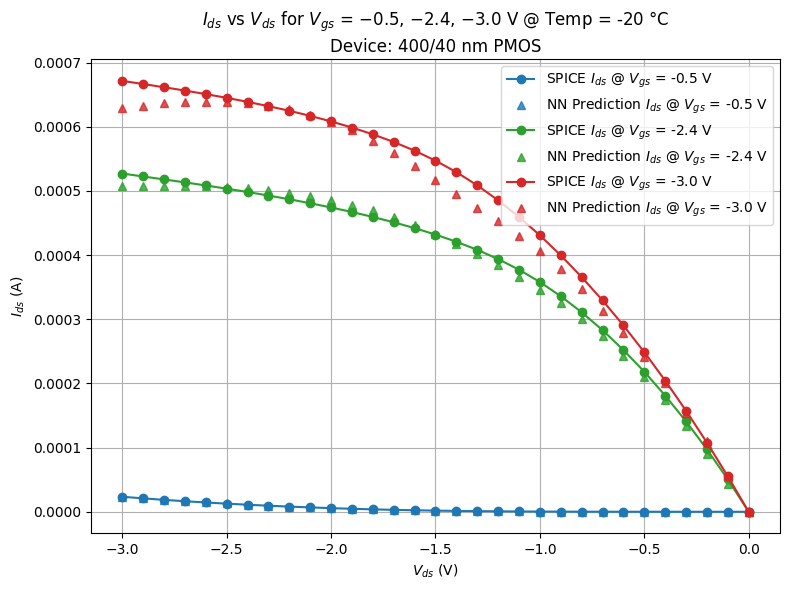

In [69]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# File for PMOS Device 1
df_spice = pd.read_csv("/content/pfet_400_40_-20_80.csv").sort_values(by=["Vgs(V)", "Vds(V)"])
signature = device_signatures[3]  # PCA vector for pfet_120_40
TEMP_TARGET = -20
VGS_TARGETS = [-0.5, -2.4, -3.0]

# Color map for each Vgs
color_map = {
    -0.5: '#1f77b4',   # blue
    -2.4: '#2ca02c',   # green
    -3.0: '#d62728'    # red
}

# Initialize combined plot
plt.figure(figsize=(8, 6))

for VGS_TARGET in VGS_TARGETS:
    color = color_map[VGS_TARGET]

    # Filter SPICE data
    mask = (df_spice["Vgs(V)"] == VGS_TARGET) & (df_spice["Temp"] == TEMP_TARGET)
    df_filtered = df_spice[mask].sort_values(by="Vds(V)")

    if df_filtered.empty:
        print(f"⚠️ No SPICE data found for Vgs = {VGS_TARGET} V at {TEMP_TARGET}°C")
        continue

    # Prepare model input
    X_input = [[*signature, row["Vgs(V)"], row["Vds(V)"], row["Temp"]] for _, row in df_filtered.iterrows()]
    X_scaled_input = scaler.transform(X_input)
    y_pred = model.predict(X_scaled_input)
    log_Id_pred = y_pred[:, 0]
    Id_pred = 10 ** log_Id_pred

    # Extract values
    Id_spice = df_filtered["Id(A)"].values
    Vds_vals = df_filtered["Vds(V)"].values

    # Plot SPICE and NN with same color, but different markers
    plt.plot(Vds_vals, Id_spice, "o-", color=color, label=f"SPICE $I_{{ds}}$ @ $V_{{gs}}$ = {VGS_TARGET} V")
    plt.plot(Vds_vals, Id_pred, "^", color=color, linestyle="None", alpha=0.8, label=f"NN Prediction $I_{{ds}}$ @ $V_{{gs}}$ = {VGS_TARGET} V")

# Final labels and styling
plt.xlabel("$V_{ds}$ (V)")
plt.ylabel("$I_{ds}$ (A)")
plt.title(f"$I_{{ds}}$ vs $V_{{ds}}$ for $V_{{gs}}$ = −0.5, −2.4, −3.0 V @ Temp = {TEMP_TARGET} °C\nDevice: 400/40 nm PMOS")
plt.legend(loc="upper right")
plt.grid(True)
plt.tight_layout()
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


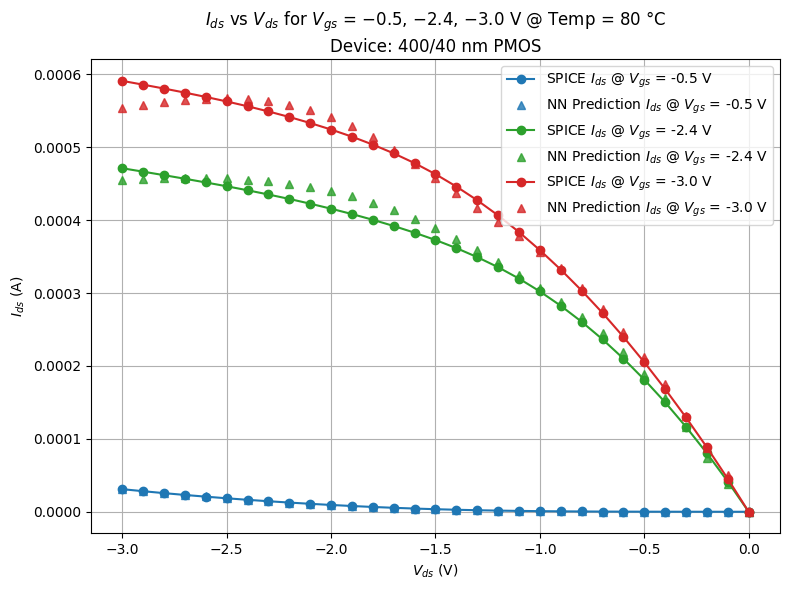

In [70]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# File for PMOS Device 1
df_spice = pd.read_csv("/content/pfet_400_40_-20_80.csv").sort_values(by=["Vgs(V)", "Vds(V)"])
signature = device_signatures[3]  # PCA vector for pfet_120_40
TEMP_TARGET = 80
VGS_TARGETS = [-0.5, -2.4, -3.0]

# Color map for each Vgs
color_map = {
    -0.5: '#1f77b4',   # blue
    -2.4: '#2ca02c',   # green
    -3.0: '#d62728'    # red
}

# Initialize combined plot
plt.figure(figsize=(8, 6))

for VGS_TARGET in VGS_TARGETS:
    color = color_map[VGS_TARGET]

    # Filter SPICE data
    mask = (df_spice["Vgs(V)"] == VGS_TARGET) & (df_spice["Temp"] == TEMP_TARGET)
    df_filtered = df_spice[mask].sort_values(by="Vds(V)")

    if df_filtered.empty:
        print(f"⚠️ No SPICE data found for Vgs = {VGS_TARGET} V at {TEMP_TARGET}°C")
        continue

    # Prepare model input
    X_input = [[*signature, row["Vgs(V)"], row["Vds(V)"], row["Temp"]] for _, row in df_filtered.iterrows()]
    X_scaled_input = scaler.transform(X_input)
    y_pred = model.predict(X_scaled_input)
    log_Id_pred = y_pred[:, 0]
    Id_pred = 10 ** log_Id_pred

    # Extract values
    Id_spice = df_filtered["Id(A)"].values
    Vds_vals = df_filtered["Vds(V)"].values

    # Plot SPICE and NN with same color, but different markers
    plt.plot(Vds_vals, Id_spice, "o-", color=color, label=f"SPICE $I_{{ds}}$ @ $V_{{gs}}$ = {VGS_TARGET} V")
    plt.plot(Vds_vals, Id_pred, "^", color=color, linestyle="None", alpha=0.8, label=f"NN Prediction $I_{{ds}}$ @ $V_{{gs}}$ = {VGS_TARGET} V")

# Final labels and styling
plt.xlabel("$V_{ds}$ (V)")
plt.ylabel("$I_{ds}$ (A)")
plt.title(f"$I_{{ds}}$ vs $V_{{ds}}$ for $V_{{gs}}$ = −0.5, −2.4, −3.0 V @ Temp = {TEMP_TARGET} °C\nDevice: 400/40 nm PMOS")
plt.legend(loc="upper right")
plt.grid(True)
plt.tight_layout()
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


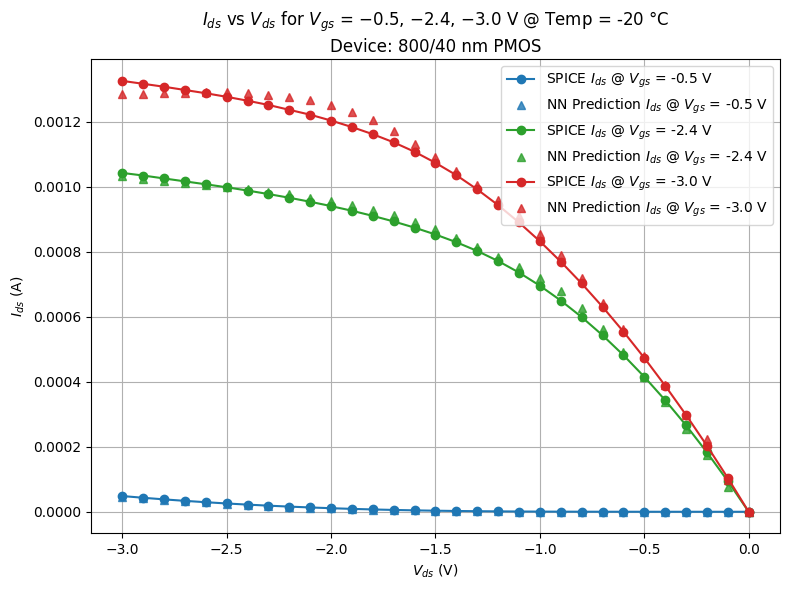

In [71]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# File for PMOS Device 1
df_spice = pd.read_csv("/content/pfet_800_40_-20_80.csv").sort_values(by=["Vgs(V)", "Vds(V)"])
signature = device_signatures[4]  # PCA vector for pfet_120_40
TEMP_TARGET = -20
VGS_TARGETS = [-0.5, -2.4, -3.0]

# Color map for each Vgs
color_map = {
    -0.5: '#1f77b4',   # blue
    -2.4: '#2ca02c',   # green
    -3.0: '#d62728'    # red
}

# Initialize combined plot
plt.figure(figsize=(8, 6))

for VGS_TARGET in VGS_TARGETS:
    color = color_map[VGS_TARGET]

    # Filter SPICE data
    mask = (df_spice["Vgs(V)"] == VGS_TARGET) & (df_spice["Temp"] == TEMP_TARGET)
    df_filtered = df_spice[mask].sort_values(by="Vds(V)")

    if df_filtered.empty:
        print(f"⚠️ No SPICE data found for Vgs = {VGS_TARGET} V at {TEMP_TARGET}°C")
        continue

    # Prepare model input
    X_input = [[*signature, row["Vgs(V)"], row["Vds(V)"], row["Temp"]] for _, row in df_filtered.iterrows()]
    X_scaled_input = scaler.transform(X_input)
    y_pred = model.predict(X_scaled_input)
    log_Id_pred = y_pred[:, 0]
    Id_pred = 10 ** log_Id_pred

    # Extract values
    Id_spice = df_filtered["Id(A)"].values
    Vds_vals = df_filtered["Vds(V)"].values

    # Plot SPICE and NN with same color, but different markers
    plt.plot(Vds_vals, Id_spice, "o-", color=color, label=f"SPICE $I_{{ds}}$ @ $V_{{gs}}$ = {VGS_TARGET} V")
    plt.plot(Vds_vals, Id_pred, "^", color=color, linestyle="None", alpha=0.8, label=f"NN Prediction $I_{{ds}}$ @ $V_{{gs}}$ = {VGS_TARGET} V")

# Final labels and styling
plt.xlabel("$V_{ds}$ (V)")
plt.ylabel("$I_{ds}$ (A)")
plt.title(f"$I_{{ds}}$ vs $V_{{ds}}$ for $V_{{gs}}$ = −0.5, −2.4, −3.0 V @ Temp = {TEMP_TARGET} °C\nDevice: 800/40 nm PMOS")
plt.legend(loc="upper right")
plt.grid(True)
plt.tight_layout()
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


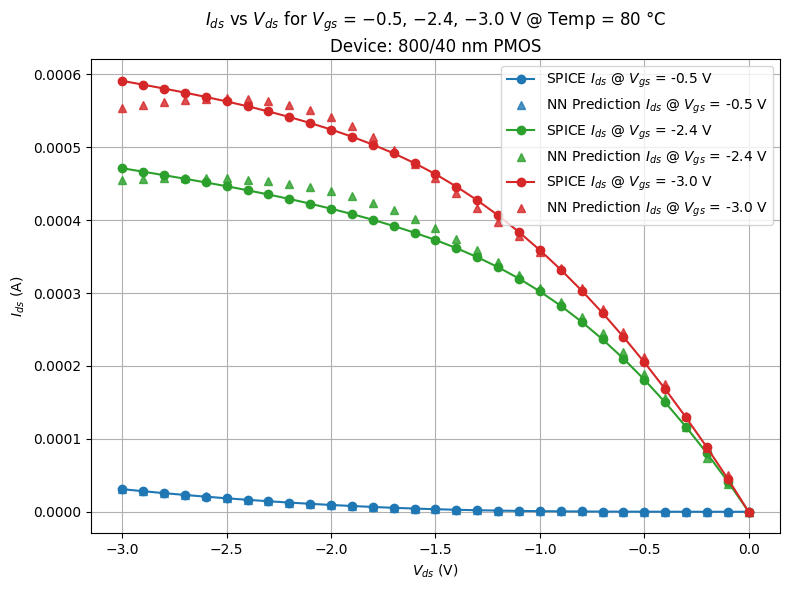

In [72]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# File for PMOS Device 1
df_spice = pd.read_csv("/content/pfet_400_40_-20_80.csv").sort_values(by=["Vgs(V)", "Vds(V)"])
signature = device_signatures[3]  # PCA vector for pfet_120_40
TEMP_TARGET = 80
VGS_TARGETS = [-0.5, -2.4, -3.0]

# Color map for each Vgs
color_map = {
    -0.5: '#1f77b4',   # blue
    -2.4: '#2ca02c',   # green
    -3.0: '#d62728'    # red
}

# Initialize combined plot
plt.figure(figsize=(8, 6))

for VGS_TARGET in VGS_TARGETS:
    color = color_map[VGS_TARGET]

    # Filter SPICE data
    mask = (df_spice["Vgs(V)"] == VGS_TARGET) & (df_spice["Temp"] == TEMP_TARGET)
    df_filtered = df_spice[mask].sort_values(by="Vds(V)")

    if df_filtered.empty:
        print(f"⚠️ No SPICE data found for Vgs = {VGS_TARGET} V at {TEMP_TARGET}°C")
        continue

    # Prepare model input
    X_input = [[*signature, row["Vgs(V)"], row["Vds(V)"], row["Temp"]] for _, row in df_filtered.iterrows()]
    X_scaled_input = scaler.transform(X_input)
    y_pred = model.predict(X_scaled_input)
    log_Id_pred = y_pred[:, 0]
    Id_pred = 10 ** log_Id_pred

    # Extract values
    Id_spice = df_filtered["Id(A)"].values
    Vds_vals = df_filtered["Vds(V)"].values

    # Plot SPICE and NN with same color, but different markers
    plt.plot(Vds_vals, Id_spice, "o-", color=color, label=f"SPICE $I_{{ds}}$ @ $V_{{gs}}$ = {VGS_TARGET} V")
    plt.plot(Vds_vals, Id_pred, "^", color=color, linestyle="None", alpha=0.8, label=f"NN Prediction $I_{{ds}}$ @ $V_{{gs}}$ = {VGS_TARGET} V")

# Final labels and styling
plt.xlabel("$V_{ds}$ (V)")
plt.ylabel("$I_{ds}$ (A)")
plt.title(f"$I_{{ds}}$ vs $V_{{ds}}$ for $V_{{gs}}$ = −0.5, −2.4, −3.0 V @ Temp = {TEMP_TARGET} °C\nDevice: 800/40 nm PMOS")
plt.legend(loc="upper right")
plt.grid(True)
plt.tight_layout()
plt.show()
